In [5]:
# Import necessary Libraries
import os
import glob
import copy
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import kagglehub

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score, cohen_kappa_score, average_precision_score, fbeta_score
import torchvision
import torchvision.transforms.v2 as T

import lightly
from lightly.loss import NTXentLoss, NegativeCosineSimilarity, SwaVLoss
from lightly.models.modules import (
    SimCLRProjectionHead, 
    BYOLProjectionHead, BYOLPredictionHead, 
    MoCoProjectionHead, 
    SwaVProjectionHead, SwaVPrototypes
)
from lightly.transforms.simclr_transform import SimCLRTransform
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.transforms.moco_transform import MoCoV2Transform
from lightly.transforms.swav_transform import SwaVTransform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True
cudnn.deterministic = False

In [7]:
import kagglehub

# Download / Load CheXpert
path = kagglehub.dataset_download("ashery/chexpert")
print("Path to dataset files:", path)

train_paths = sorted(glob.glob(os.path.join(path, "train", "patient*", "study*", "*.jpg")))
test_paths   = sorted(glob.glob(os.path.join(path, "train", "patient*", "study*", "*.jpg")))

train_csv = pd.read_csv("train_split.csv").sort_values(by="Path")
test_csv = pd.read_csv("test_split.csv").sort_values(by="Path")

target_columns = [
    "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", 
    "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax", 
    "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"
]

# Replace negative values and fill NaN for labels
train_csv[target_columns] = train_csv[target_columns].replace(-1, 0).fillna(0)
test_csv[target_columns] = test_csv[target_columns].replace(-1, 0).fillna(0)

# Dataset Root
dataset_root = "/home/ubuntu/.cache/kagglehub/datasets/ashery/chexpert/versions/1"

# Correct paths
train_csv['Full_Path'] = train_csv['Path'].apply(
    lambda x: os.path.join(dataset_root, x.replace("CheXpert-v1.0-small/", ""))
)
test_csv['Full_Path'] = test_csv['Path'].apply(
    lambda x: os.path.join(dataset_root, x.replace("CheXpert-v1.0-small/", ""))
)

# Filter Missing Files
train_csv = train_csv[train_csv['Full_Path'].apply(os.path.exists)]
test_csv = test_csv[test_csv['Full_Path'].apply(os.path.exists)]

# Update paths and labels
train_paths = train_csv['Full_Path'].tolist()
test_paths = test_csv['Full_Path'].tolist()
train_label_dict = train_csv.set_index('Full_Path')[target_columns].to_dict('index')
test_label_dict = test_csv.set_index('Full_Path')[target_columns].to_dict('index')
train_labels = [list(train_label_dict[path].values()) for path in train_paths]
test_labels = [list(test_label_dict[path].values()) for path in test_paths]

# Subset Data
def subset_data(paths, labels, fraction=0.1):
    subset_size = int(len(paths) * fraction)
    return paths[:subset_size], labels[:subset_size]

# Create subsets
train_paths_10, train_labels_10 = subset_data(train_paths, train_labels, fraction=0.1)
train_paths_50, train_labels_50 = subset_data(train_paths, train_labels, fraction=0.5)
train_paths_100, train_labels_100 = train_paths, train_labels

Resuming download from 268435456 bytes (11227695053 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/ashery/chexpert?dataset_version_number=1 (268435456/11496130509) bytes left.


100%|██████████| 10.7G/10.7G [01:29<00:00, 126MB/s] 

Extracting files...


Path to dataset files: /home/ubuntu/.cache/kagglehub/datasets/ashery/chexpert/versions/1


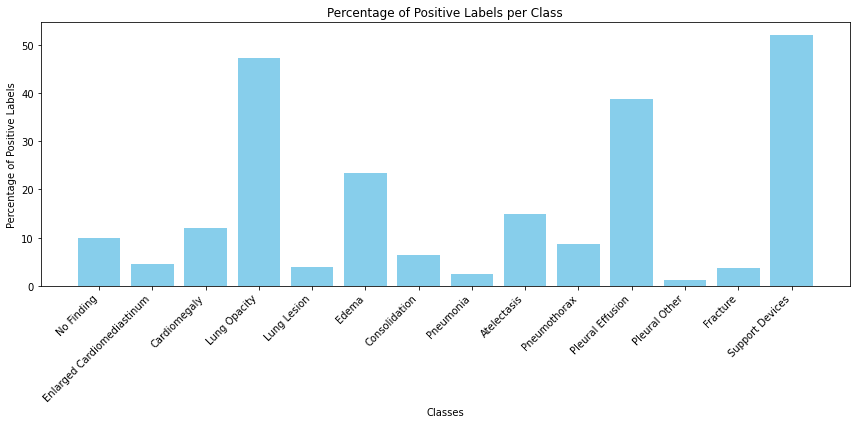

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate percentage of positive labels for each class
def calculate_positive_percentage(labels, target_columns):
    label_array = np.array(labels)
    positive_counts = label_array.sum(axis=0)
    total_counts = label_array.shape[0]
    return (positive_counts / total_counts) * 100

# Compute percentages for training data
positive_percentages = calculate_positive_percentage(train_labels, target_columns)

# Plot the percentages
plt.figure(figsize=(12, 6))
plt.bar(target_columns, positive_percentages, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Percentage of Positive Labels')
plt.title('Percentage of Positive Labels per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [8]:
class CheXpertSSLRawDataset(Dataset):
    # A dataset for SSL that returns raw images and lets the transform handle multiple views.
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed to load {img_path}")
        # Basic preprocessing
        img = cv2.fastNlMeansDenoising(img, None, h=10)
        img = cv2.equalizeHist(img)
        img = img.astype(np.float32)
        mean,std = img.mean(), img.std()
        img=(img-mean)/(std+1e-8)
        # 3-channel
        img = np.stack([img,img,img], axis=-1).astype(np.uint8)
        img = torchvision.transforms.ToPILImage()(img)
        return self.transform(img), 0

    def __len__(self):
        return len(self.image_paths)

class CheXpertLabeledDataset(Dataset):
    #A dataset class for supervised learning that processes images and provides corresponding labels.
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform if transform else T.Compose([
            T.ToPILImage(),
            T.Resize((224,224)),
            T.ToTensor()
        ])

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        lbl=torch.tensor(self.labels[idx],dtype=torch.float32)
        img=cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed to load {img_path}")
        img=cv2.fastNlMeansDenoising(img,None,h=10)
        img=cv2.equalizeHist(img)
        img=img.astype(np.float32)
        m,s=img.mean(),img.std()
        img=(img-m)/(s+1e-8)
        img=np.stack([img,img,img],axis=-1)
        img=self.transform(img)
        return img,lbl

    def __len__(self):
        return len(self.image_paths)


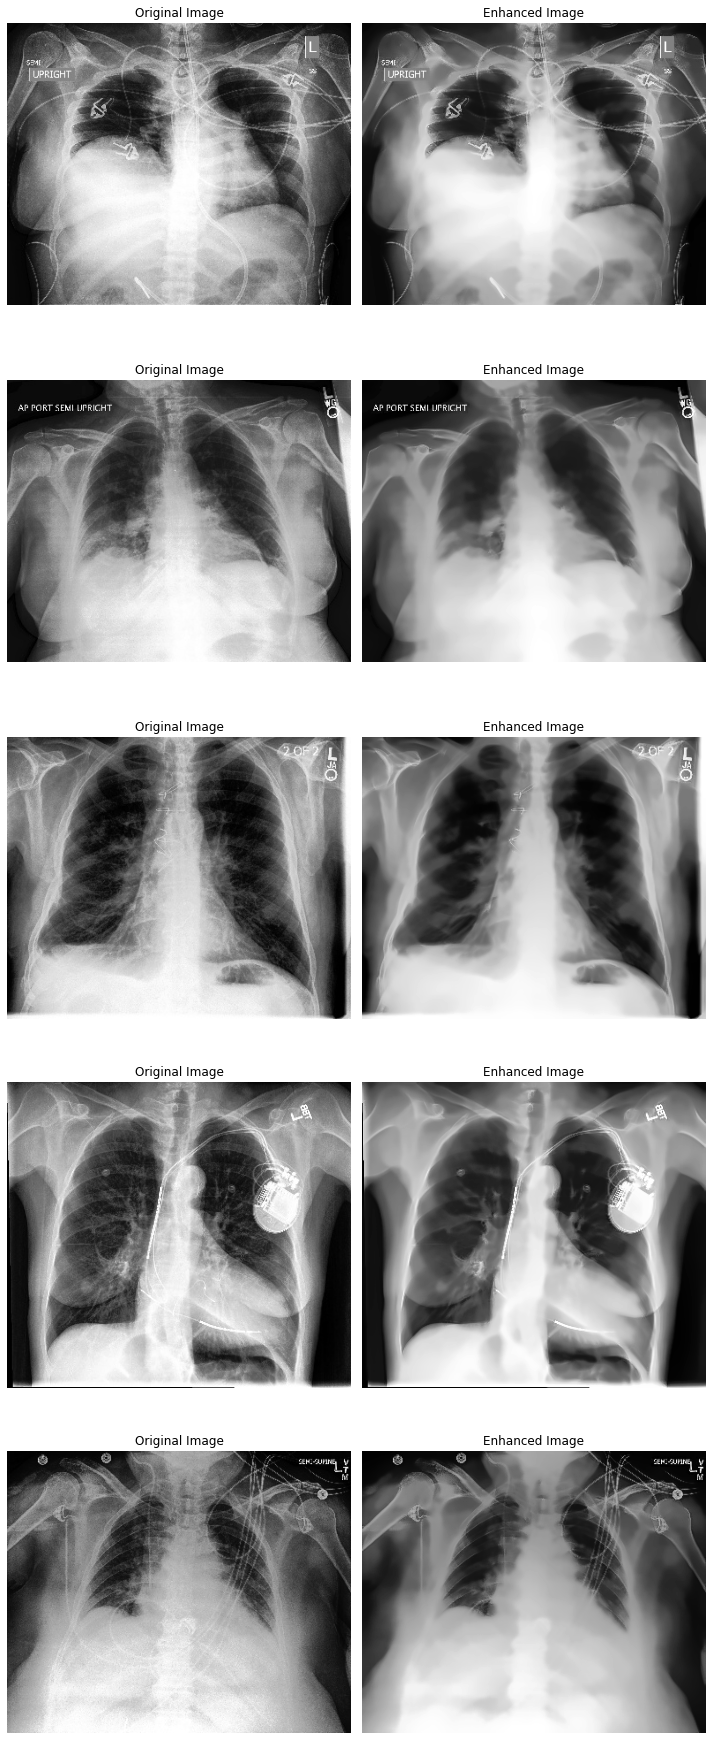

In [9]:
import random
import matplotlib.pyplot as plt

# Visualize a few images before and after enhancement
num_images_to_visualize = 5

# Ensure there are enough images in the dataset
if num_images_to_visualize > len(train_paths):
    raise ValueError("num_images_to_visualize is greater than the number of available images.")

# Select random images for visualization
random_indices = random.sample(range(len(train_paths)), num_images_to_visualize)

# Prepare subplots
fig, axes = plt.subplots(num_images_to_visualize, 2, figsize=(10, 5 * num_images_to_visualize))

for idx, sample_idx in enumerate(random_indices):
    img_path = train_paths[sample_idx]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image at {img_path}. Skipping.")
        continue

    # Original image
    original_img = img.copy()

    # Apply preprocessing
    img = cv2.fastNlMeansDenoising(img, None, h=10)
    img = cv2.equalizeHist(img)
    enhanced_img = img.copy()

    # Display original and enhanced images
    axes[idx, 0].imshow(original_img, cmap='gray')
    axes[idx, 0].set_title("Original Image")
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(enhanced_img, cmap='gray')
    axes[idx, 1].set_title("Enhanced Image")
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()


In [10]:
# Creates a WeightedRandomSampler to handle class imbalance in multi-label datasets.
def create_weighted_sampler(paths, labels):
    arr = np.array(labels)
    class_counts=arr.sum(axis=0)
    total=len(arr)
    class_weights=[]
    for c in class_counts:
        if c==0:
            class_weights.append(0.)
        else:
            class_weights.append(total/(c*len(target_columns)))
    class_weights=np.array(class_weights)

    sample_w=[]
    for lab in arr:
        pos=np.where(lab==1)[0]
        if len(pos)>0:
            w=class_weights[pos].sum()
        else:
            w=0.1
        sample_w.append(w)
    sampler=WeightedRandomSampler(sample_w,len(sample_w),replacement=True)
    return sampler

class FocalLoss(nn.Module):
    """
    Implements Focal Loss for addressing class imbalance in binary classification tasks.

    Args:
    - alpha: A scaling factor to balance positive and negative examples (default: 1).
    - gamma: A focusing parameter to down-weight easy examples (default: 2).
    """
    def __init__(self,alpha=1,gamma=2):
        super().__init__()
        self.alpha=alpha
        self.gamma=gamma
    def forward(self,inp,tgt):
        bce=nn.BCEWithLogitsLoss()(inp,tgt)
        pt=torch.exp(-bce)
        return self.alpha*(1-pt)**self.gamma*bce

In [11]:
# A utility class to compute evaluation metrics for multi-label classification.
class Metrics:
    @staticmethod
    def compute_per_class_metrics(preds,labels):
        num_classes=labels.shape[1]
        auc,f1,kappa,ap=[],[],[],[]
        for i in range(num_classes):
            y_true=labels[:,i]
            y_pred=preds[:,i]
            if len(np.unique(y_true))<2:
                auc.append(np.nan)
                f1.append(np.nan)
                kappa.append(np.nan)
                ap.append(np.nan)
                continue
            auc.append(roc_auc_score(y_true,y_pred))
            f1.append(fbeta_score(y_true,y_pred>0.5,beta=1))
            kappa.append(cohen_kappa_score(y_true,(y_pred>0.5).astype(int)))
            ap.append(average_precision_score(y_true,y_pred))
        return {
            "AUC_per_class":auc,
            "F1_per_class":f1,
            "Cohen_Kappa_per_class":kappa,
            "Average_Precision_per_class":ap
        }

In [13]:
# Transformation for SimCLR
simclr_transform = SimCLRTransform(
    input_size=224,
    gaussian_blur=0.1,
    cj_prob=0.8,
    cj_strength=0.5
)
# SimCLR uses strong augmentations like color jitter and Gaussian blur to create positive pairs.

# Transformation for BYOL
byol_transform = BYOLTransform(
    view_1_transform=BYOLView1Transform(input_size=224,gaussian_blur=0.1),
    view_2_transform=BYOLView2Transform(input_size=224,gaussian_blur=0.1)
)
# BYOL uses two augmented views of the same image (view_1 and view_2) for training.
# These views are created using different augmentations to enforce consistency between the two views.

# Transformation for MoCo
moco_transform = MoCoV2Transform(input_size=224)
# MoCo uses a single transformation pipeline that generates augmented views for the momentum contrastive framework.

# Transformation for SwAV
swav_transform = SwaVTransform()
# SwAV employs a multi-crop strategy:
# - Creates 2 global crops (large views) and 6 smaller crops (local views).
# - Designed to learn representations invariant to spatial transformations.

# Transformation for test/validation datasets
test_transform=T.Compose([
    T.ToPILImage(),
    T.Resize((224,224)),
    T.ToTensor()
])

In [14]:
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR
from torch.nn.utils import clip_grad_norm_

# Pretraining function for SimCLR
def pretrain_simclr(train_paths, epochs=100):
    ssl_dataset = CheXpertSSLRawDataset(train_paths, transform=simclr_transform)
    ssl_loader = DataLoader(ssl_dataset,batch_size=512,shuffle=True,drop_last=True,num_workers=8)

    backbone = torchvision.models.resnet50(weights=None)
    backbone.fc = nn.Identity()
    projector = SimCLRProjectionHead(2048,2048,128)
    model = nn.Sequential(backbone,projector).to(device)
    criterion = NTXentLoss(temperature=0.5)
    optimizer = optim.SGD(model.parameters(),lr=0.03,momentum=0.9,weight_decay=1e-4)
    
    # OneCycleLR scheduler
    steps_per_epoch = len(ssl_loader)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=0.03,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1e4
    )
    
    scaler = GradScaler(device='cuda')

    for epoch in range(epochs):
        model.train()
        total_loss=0
        for ((x0,x1),_) in tqdm(ssl_loader,desc=f"SimCLR epoch {epoch+1}/{epochs}",leave=False):
            x0,x1 = x0.to(device), x1.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', dtype=torch.float16):
                z0 = model(x0)
                z1 = model(x1)
                loss = criterion(z0,z1)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)  # Unscale gradients first
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            
            total_loss+=loss.item()
        print(f"[SimCLR] Epoch {epoch+1}, Loss={total_loss/len(ssl_loader):.4f}")
    return copy.deepcopy(backbone)

In [25]:
# Pretraining function for BYOL
def pretrain_byol(train_paths, epochs=100):
    ssl_dataset=CheXpertSSLRawDataset(train_paths, transform=byol_transform)
    ssl_loader=DataLoader(ssl_dataset,batch_size=256,shuffle=True,drop_last=True,num_workers=8)

    backbone=torchvision.models.resnet50(weights=None)
    backbone.fc=nn.Identity()
    online_proj=BYOLProjectionHead(2048,1024,256)
    online_pred=BYOLPredictionHead(256,1024,256)
    backbone = backbone.to(device)
    online_proj = online_proj.to(device)
    online_pred = online_pred.to(device)
    target_backbone=copy.deepcopy(backbone)
    target_proj=copy.deepcopy(online_proj)
    for p in target_backbone.parameters():
        p.requires_grad=False
    for p in target_proj.parameters():
        p.requires_grad=False

    criterion=NegativeCosineSimilarity()
    optimizer=optim.Adam(backbone.parameters(),lr=1e-3,weight_decay=1e-6)
    m=0.99
    scaler = GradScaler(device='cuda')

    steps_per_epoch = len(ssl_loader)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=0.01,  # example max_lr higher than base for 1cycle
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1e4
    )

    for epoch in range(epochs):
        backbone.train()
        total_loss=0
        for ((x0,x1),_) in tqdm(ssl_loader,desc=f"BYOL epoch {epoch+1}/{epochs}",leave=False):
            x0,x1=x0.to(device),x1.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda'):
                o0=online_proj(backbone(x0).flatten(1))
                p0=online_pred(o0)
                o1=online_proj(backbone(x1).flatten(1))
                p1=online_pred(o1)
                with torch.no_grad():
                    t0=target_proj(target_backbone(x0).flatten(1))
                    t1=target_proj(target_backbone(x1).flatten(1))
                loss=0.5*(criterion(p0,t1)+criterion(p1,t0))

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)  # Unscale gradients before clipping
            clip_grad_norm_(backbone.parameters(), max_norm=1.0)
            clip_grad_norm_(online_proj.parameters(), max_norm=1.0)
            clip_grad_norm_(online_pred.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            total_loss+=loss.item()

            # update target
            for po,pt in zip(backbone.parameters(), target_backbone.parameters()):
                pt.data=pt.data*m+po.data*(1-m)
            for po,pt in zip(online_proj.parameters(), target_proj.parameters()):
                pt.data=pt.data*m+po.data*(1-m)

        print(f"[BYOL] Epoch {epoch+1}, Loss={total_loss/len(ssl_loader):.4f}")
    return copy.deepcopy(backbone)

In [16]:
# Pretraining function for MoCo
def pretrain_moco(train_paths, epochs=100, K=65536, m=0.999, T=0.2):
    ssl_dataset=CheXpertSSLRawDataset(train_paths, transform=moco_transform)
    ssl_loader=DataLoader(ssl_dataset,batch_size=512,shuffle=True,drop_last=True,num_workers=8)
    backbone_q=torchvision.models.resnet50(weights=None)
    backbone_q.fc=nn.Identity()
    fc_q=MoCoProjectionHead(2048,2048,128)
    model_q=nn.Sequential(backbone_q,fc_q).to(device)

    backbone_k=copy.deepcopy(backbone_q)
    fc_k=copy.deepcopy(fc_q)
    for p in backbone_k.parameters():
        p.requires_grad=False
    for p in fc_k.parameters():
        p.requires_grad=False

    queue = torch.randn(128,K, device=device)
    queue=F.normalize(queue,dim=0)
    queue_ptr=0

    optimizer=optim.SGD(model_q.parameters(),lr=0.03,momentum=0.9,weight_decay=1e-4)
    scaler=GradScaler(device='cuda')

    steps_per_epoch = len(ssl_loader)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=0.03,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1e4
    )

    def momentum_update():
        for param_q,param_k in zip(backbone_q.parameters(), backbone_k.parameters()):
            param_k.data = param_k.data*m+param_q.data*(1-m)
        for param_q,param_k in zip(fc_q.parameters(), fc_k.parameters()):
            param_k.data=param_k.data*m+param_q.data*(1-m)

    @torch.no_grad()
    def dequeue_and_enqueue(keys):
        nonlocal queue_ptr
        batch_size=keys.shape[0]
        if queue_ptr+batch_size<=K:
            queue[:,queue_ptr:queue_ptr+batch_size]=keys.T
            queue_ptr=(queue_ptr+batch_size)%K
        else:
            end=K-queue_ptr
            queue[:,queue_ptr:]=keys[:end].T
            overflow=batch_size-end
            queue[:,:overflow]=keys[end:].T
            queue_ptr=overflow

    for epoch in range(epochs):
        model_q.train()
        total_loss=0
        for ((xq,xk),_) in tqdm(ssl_loader,desc=f"MoCo epoch {epoch+1}/{epochs}",leave=False):
            xq,xk=xq.to(device),xk.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', dtype=torch.float16):
                q = model_q(xq)
                q=F.normalize(q,dim=1)

                with torch.no_grad():
                    momentum_update()
                    k = backbone_k(xk)
                    k=fc_k(k)
                    k=F.normalize(k,dim=1)
                l_pos=(q*k).sum(dim=1,keepdim=True)
                l_neg=torch.mm(q,queue.clone().detach())
                logits=torch.cat([l_pos,l_neg],dim=1)
                logits/=T
                labels=torch.zeros(logits.size(0),dtype=torch.long,device=device)
                loss=F.cross_entropy(logits,labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)  # Unscale gradients first
            clip_grad_norm_(model_q.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            total_loss+=loss.item()

            dequeue_and_enqueue(k)

        print(f"[MoCo] Epoch {epoch+1}, Loss={total_loss/len(ssl_loader):.4f}")
    return copy.deepcopy(backbone_q)


In [24]:
# Pretraining function for SwaV
def pretrain_swav(train_paths, epochs=100, n_prototypes=3000):
    ssl_dataset=CheXpertSSLRawDataset(train_paths, transform=swav_transform)
    ssl_loader=DataLoader(ssl_dataset,batch_size=256,shuffle=True,drop_last=True,num_workers=8)

    backbone=torchvision.models.resnet50(weights=None)
    backbone.fc=nn.Identity()
    proj=SwaVProjectionHead(2048,2048,128)
    backbone = backbone.to(device)
    proj = proj.to(device)
    prototypes = SwaVPrototypes(128, n_prototypes=n_prototypes).to(device)
    model=nn.Sequential(backbone,proj).to(device)
    criterion=SwaVLoss(sinkhorn_iterations=3)
    optimizer=optim.SGD(model.parameters(),lr=0.03,momentum=0.9,weight_decay=1e-4)
    scaler=GradScaler(device='cuda')

    steps_per_epoch = len(ssl_loader)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=0.03,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1e4
    )

    for epoch in range(epochs):
        model.train()
        total_loss=0
        prototypes.normalize()
        for (multi_views,_) in tqdm(ssl_loader,desc=f"SwAV epoch {epoch+1}/{epochs}",leave=False):
            multi_views = [v.to(device) for v in multi_views]
            with torch.no_grad():
                prototypes.normalize()

            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', dtype=torch.float16):
                z=[]
                for v in multi_views:
                    h=model(v)
                    h=F.normalize(h,dim=1)
                    z.append(h)

                loss=criterion(z[:2], z[2:])

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)  # Unscale gradients before clipping
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            total_loss+=loss.item()

        print(f"[SwAV] Epoch {epoch+1}, Loss={total_loss/len(ssl_loader):.4f}")
    return copy.deepcopy(backbone)

In [18]:
def fine_tune_ssl(pretrained_backbone, train_paths_subset, train_labels_subset, test_paths, test_labels, epochs=20):
    # Create a classification model by attaching a linear head to the pretrained backbone
    classification_model=nn.Sequential(
        pretrained_backbone, # # Pretrained backbone (e.g., from SSL methods like SimCLR, MoCo, etc.)
        nn.Linear(2048,len(target_columns))
    ).to(device)

    sampler=create_weighted_sampler(train_paths_subset,train_labels_subset)
    train_ds=CheXpertLabeledDataset(train_paths_subset,train_labels_subset,transform=test_transform)
    train_loader=DataLoader(train_ds,batch_size=512,sampler=sampler,num_workers=8)

    test_ds=CheXpertLabeledDataset(test_paths,test_labels,transform=test_transform)
    test_loader=DataLoader(test_ds,batch_size=512,shuffle=False,num_workers=8)

    criterion=FocalLoss()
    optimizer=optim.AdamW(classification_model.parameters(),lr=1e-3,weight_decay=0.01)
    scaler=GradScaler(device='cuda')

    steps_per_epoch = len(train_loader)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=0.01,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1e4
    )

    # Training loop for fine-tuning
    for epoch in range(epochs):
        classification_model.train()
        total_loss=0
        for imgs,lbl in tqdm(train_loader,desc=f"Fine-tune epoch {epoch+1}/{epochs}",leave=False):
            imgs,lbl=imgs.to(device),lbl.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', dtype=torch.float16):
                out=classification_model(imgs)
                loss=criterion(out,lbl)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)  # Unscale gradients before clipping
            clip_grad_norm_(classification_model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            total_loss+=loss.item()
        avg=total_loss/len(train_loader)
        print(f"[Fine-tune] Epoch {epoch+1}/{epochs}, Loss={avg:.4f}")

        classification_model.eval()
        test_preds,test_gt=[],[]
        with torch.no_grad():
            for imgs,lbl in test_loader:
                imgs,lbl=imgs.to(device),lbl.to(device)
                o=torch.sigmoid(classification_model(imgs))
                test_preds.append(o.cpu().numpy())
                test_gt.append(lbl.cpu().numpy())
        test_preds=np.concatenate(test_preds,0)
        test_gt=np.concatenate(test_gt,0)

        # Compute evaluation metrics for each class
        m=Metrics.compute_per_class_metrics(test_preds,test_gt)
        print("AUC:",m["AUC_per_class"])
        print("F1:",m["F1_per_class"])
        print("Cohen Kappa:",m["Cohen_Kappa_per_class"])
        print("Average Precision:",m["Average_Precision_per_class"])
    return classification_model

In [19]:
class BaselineModel:
    # A class for training and evaluating baseline supervised models for multi-label classification.
    def __init__(self,model_name):
        self.model_name = model_name
        if model_name=="resnet50":
            self.model=torchvision.models.resnet50(weights=None)
            self.model.fc=nn.Linear(2048,len(target_columns))
        elif model_name=="inception_v3":
            self.model=torchvision.models.inception_v3(weights=None,aux_logits=False, init_weights=True)
            self.model.fc=nn.Linear(2048,len(target_columns))
        else:
            raise ValueError("Unsupported model")
        self.model.to(device)

    def train_model(self,train_paths,train_labels,test_paths,test_labels,epochs=20):
        # Trains and evaluates the baseline model on the given dataset.
        sampler=create_weighted_sampler(train_paths,train_labels)
        train_ds=CheXpertLabeledDataset(train_paths,train_labels,transform=test_transform)
        train_loader=DataLoader(train_ds,batch_size=512,sampler=sampler,num_workers=8)

        test_ds=CheXpertLabeledDataset(test_paths,test_labels,transform=test_transform)
        test_loader=DataLoader(test_ds,batch_size=512,shuffle=False,num_workers=8)

        criterion=FocalLoss()
        optimizer=optim.AdamW(self.model.parameters(),lr=1e-3,weight_decay=0.01)
        scaler=GradScaler(device='cuda')

        steps_per_epoch = len(train_loader)
        scheduler = OneCycleLR(
            optimizer,
            max_lr=0.01,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            pct_start=0.3,
            anneal_strategy='cos',
            div_factor=25.0,
            final_div_factor=1e4
        )

        for epoch in range(epochs):
            self.model.train()
            total_loss=0
            for imgs,lbl in tqdm(train_loader,desc=f"{self.model_name} Supervised epoch {epoch+1}/{epochs}",leave=False):
                imgs,lbl=imgs.to(device),lbl.to(device)
                
                optimizer.zero_grad(set_to_none=True)
                with autocast(device_type='cuda', dtype=torch.float16):
                    out=self.model(imgs)
                    loss=criterion(out,lbl)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

                total_loss+=loss.item()
            avg=total_loss/len(train_loader)
            print(f"[{self.model_name} Supervised] Epoch {epoch+1}/{epochs}, Loss={avg:.4f}")

            self.model.eval()
            test_preds,test_gt=[],[]
            with torch.no_grad():
                for imgs,lbl in test_loader:
                    imgs=imgs.to(device)
                    lbl=lbl.to(device)
                    o=torch.sigmoid(self.model(imgs))
                    test_preds.append(o.cpu().numpy())
                    test_gt.append(lbl.cpu().numpy())

            # Combine predictions and ground truth into arrays
            test_preds=np.concatenate(test_preds,0)
            test_gt=np.concatenate(test_gt,0)

            # Compute evaluation metrics for each class
            m=Metrics.compute_per_class_metrics(test_preds,test_gt)
            print("Val AUC:",m["AUC_per_class"])
            print("F1:",m["F1_per_class"])
            print("Cohen Kappa:",m["Cohen_Kappa_per_class"])
            print("Average Precision:",m["Average_Precision_per_class"])

# Due to limited computation power and cost, all models and fine tuning is done on 5 epochs which limits the results. But with access to greater computational power, these SSL Models have the potential to achieve higher performance and match or surpass supervised learning models in medical image representation.

In [22]:
# Pretrain SimCLR
print("Pretrain SimCLR")
simclr_backbone = pretrain_simclr(train_paths, epochs=5)
print("Fine-tune SimCLR model on 10% labeled dataset")
simclr_model_10 = fine_tune_ssl(simclr_backbone, train_paths_10, train_labels_10, test_paths, test_labels, epochs=5)
print("Fine-tune SimCLR model on 50% labeled dataset")
simclr_model_50 = fine_tune_ssl(simclr_backbone, train_paths_50, train_labels_50, test_paths, test_labels, epochs=5)
print("Fine-tune SimCLR model on 100% labeled dataset")
simclr_model_100 = fine_tune_ssl(simclr_backbone, train_paths_100, train_labels_100, test_paths, test_labels, epochs=5)

Pretrain SimCLR


/usr/lib/python3/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
                                                                 

[SimCLR] Epoch 1, Loss=6.8585


[SimCLR] Epoch 2, Loss=6.7548


[SimCLR] Epoch 3, Loss=6.6334


[SimCLR] Epoch 4, Loss=6.5244


[SimCLR] Epoch 5, Loss=6.4717
Fine-tune SimCLR model on 10% labeled dataset


[Fine-tune] Epoch 1/5, Loss=0.0903


AUC: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
F1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12126369535155836, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cohen Kappa: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Average Precision: [0.11063299739553845, 0.04495527120371419, 0.12025818140640925, 0.4683501302230778, 0.03793454874872608, 0.23610010191371306, 0.06454535160231005, 0.02400634129770128, 0.14381157286830484, 0.08741931831049711, 0.38761182199071453, 0.01302230777941343, 0.03770807383082324, 0.52270411051976]


[Fine-tune] Epoch 2/5, Loss=0.0742


AUC: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
F1: [0.0, 0.08604247941048981, 0.0, 0.0, 0.0, 0.0, 0.12126369535155836, 0.046887094990600474, 0.25146025146025147, 0.0, 0.0, 0.0, 0.0, 0.0]
Cohen Kappa: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Average Precision: [0.11063299739553845, 0.04495527120371419, 0.12025818140640925, 0.4683501302230778, 0.03793454874872608, 0.23610010191371306, 0.06454535160231005, 0.02400634129770128, 0.14381157286830484, 0.08741931831049711, 0.38761182199071453, 0.01302230777941343, 0.03770807383082324, 0.52270411051976]


[Fine-tune] Epoch 3/5, Loss=0.0639


AUC: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5280341624675429]
F1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.587356893977103]
Cohen Kappa: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.051374266793932755]
Average Precision: [0.11063299739553845, 0.04495527120371419, 0.12025818140640925, 0.4683501302230778, 0.03793454874872608, 0.23610010191371306, 0.06454535160231005, 0.02400634129770128, 0.14381157286830484, 0.08741931831049711, 0.38761182199071453, 0.01302230777941343, 0.03770807383082324, 0.5393857365434733]


[Fine-tune] Epoch 4/5, Loss=0.0589


AUC: [0.5186810650565241, 0.5, 0.49950464676963513, 0.49080764136504734, 0.5010436869325688, 0.5007465121884112, 0.49670911936662865, 0.4900931903407785, 0.48939267709245643, 0.5023219301691476, 0.4899665528352409, 0.49994263423588803, 0.5, 0.4957840951376511]
F1: [0.0, 0.08604247941048981, 0.0, 0.0, 0.0, 0.3823583348615441, 0.0, 0.04611819235225956, 0.0, 0.0, 0.04485049833887043, 0.0, 0.0, 0.0]
Cohen Kappa: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0007005187332820295, 0.0, -0.000750168999334333, 0.0, 0.0, 0.004467698294302935, 0.0, 0.0, 0.0]
Average Precision: [0.12216287146502705, 0.04495527120371419, 0.12020771858650366, 0.46414737577777515, 0.03851095597184228, 0.23636983581625076, 0.06426575445699453, 0.023543866868035238, 0.14298268150711735, 0.08885033077409264, 0.3794277141773369, 0.01302230777941343, 0.03770807383082324, 0.518350671110029]


[Fine-tune] Epoch 5/5, Loss=0.0556


AUC: [0.5600592986799261, 0.5271161646902397, 0.4575858493083841, 0.481312839495492, 0.5079440368777581, 0.5458561819385287, 0.4820495585896105, 0.5231848461166313, 0.49345460074335046, 0.5805284311878651, 0.4591321304540984, 0.5352046211864236, 0.5403147322422446, 0.5035332003182493]
F1: [0.0, 0.08956581041145714, 0.0, 0.005285920230658337, 0.0, 0.1619856303069889, 0.0, 0.0, 0.0, 0.0, 0.0005841121495327102, 0.0, 0.0, 0.39118607181719256]
Cohen Kappa: [0.0, 0.008461624916480837, 0.0, -0.0005689725242923327, 0.0, 0.013327538208808387, 0.0, -0.0004489180967990336, 0.0, 0.0, 0.00035778438052869177, 0.0, 0.0, 0.003509336280553277]
Average Precision: [0.139002024681805, 0.04899787850614528, 0.11007702813596751, 0.45257204446370625, 0.0388400832191072, 0.25606610700978805, 0.0637656238541801, 0.024934755270524862, 0.1465622834773227, 0.11123726438025522, 0.3658950242021138, 0.0157097764396317, 0.04622528680030344, 0.5230162670280661]
Fine-tune SimCLR model on 50% labeled dataset


[Fine-tune] Epoch 1/5, Loss=0.0689


AUC: [0.6734363234453546, 0.48035598981930516, 0.5626217021195106, 0.5792141471131682, 0.5746586629001884, 0.6671680384716835, 0.5440746734285175, 0.5136430702681877, 0.48413684187505923, 0.585770615287385, 0.6102590140314302, 0.6220982900013968, 0.5983478182819204, 0.5876908365559167]
F1: [0.0, 0.0, 0.04521739130434783, 0.6060194174757282, 0.0, 0.4459919028340081, 0.0, 0.0, 0.0, 0.0, 0.5262222222222221, 0.0, 0.0, 0.5388149369772648]
Cohen Kappa: [0.0, 0.0, 0.027315393382793318, 0.10343813912453659, 0.0, 0.1938640667891891, 0.0, -0.00022546247724775093, 0.0, 0.0, 0.15658920312592106, 0.0, 0.0, 0.11826984605755397]
Average Precision: [0.18334283664521928, 0.04405444741219981, 0.14899046060028398, 0.5245825141058725, 0.0469778935987669, 0.34857162562664284, 0.07203354774812057, 0.02554229999128696, 0.14284930260019088, 0.10643690275437187, 0.46677617983358966, 0.01956340668274777, 0.04884428880141846, 0.5773879085759572]


[Fine-tune] Epoch 2/5, Loss=0.0529


AUC: [0.7013441833418953, 0.4720583412826456, 0.5750497716672497, 0.5992880507886286, 0.6057155957500632, 0.6796328013189804, 0.5655992966316045, 0.5475485270584732, 0.5561864291166752, 0.5607014524359533, 0.6490252806026756, 0.6574256240397469, 0.6149307697907369, 0.6195607212830302]
F1: [0.0, 0.0, 0.041272570937231294, 0.6372670807453416, 0.0, 0.4080685829551186, 0.0, 0.0, 0.0, 0.0, 0.5632136011334278, 0.0, 0.0, 0.6870717902889484]
Cohen Kappa: [0.0, 0.0, 0.020819956067709033, 0.003730237564554706, 0.0, 0.05607764149896188, -0.00022612941227584393, 0.0, 0.0, 0.0, 0.020498700654680846, 0.0, 0.0, 0.0032882370706600605]
Average Precision: [0.19780371433942623, 0.0427350721776859, 0.15269609268029447, 0.5337033004543436, 0.05008750260247253, 0.3449109044452038, 0.07880490085534701, 0.029325859256036285, 0.16157541857804897, 0.1018931132549021, 0.5066916439917226, 0.02292110519519947, 0.05706724270201481, 0.6011279456687161]


[Fine-tune] Epoch 3/5, Loss=0.0483


AUC: [0.7439298414071127, 0.5341936410677902, 0.6347307457641662, 0.6178809971099753, 0.6154053180425556, 0.7159393505059576, 0.5971114537342023, 0.5402883493466607, 0.5741465477111618, 0.584185720338411, 0.694043200192917, 0.6895025640002396, 0.6311458551985736, 0.6482082025283145]
F1: [0.0, 0.0, 0.0, 0.6448613376835236, 0.0, 0.03430690774223459, 0.0, 0.0, 0.0, 0.0, 0.2616520535302261, 0.0, 0.0, 0.6915414761593729]
Cohen Kappa: [0.0, 0.0, 0.0, 0.06370566526370058, 0.0, 0.018841995032383374, 0.0, 0.0, 0.0, 0.0, 0.11791572004836437, 0.0, 0.0, 0.11510735459214039]
Average Precision: [0.23249986174962955, 0.050238752683003166, 0.17824009808265526, 0.5627805507172156, 0.05349676776311034, 0.4028983300883274, 0.08251920214392411, 0.02616867293963064, 0.1726270621738902, 0.11124425136997346, 0.5569902467953383, 0.027721857753039716, 0.05892185248279672, 0.6522059420084331]


[Fine-tune] Epoch 4/5, Loss=0.0468


AUC: [0.7689797608817418, 0.5125175536944442, 0.6305528466872662, 0.6417020195153904, 0.6125753647019142, 0.7295362879574786, 0.6135451508568055, 0.5294295512109052, 0.5893326404560493, 0.6026256648666859, 0.6901378617842752, 0.6475327733104536, 0.6156901782931438, 0.6616549070641906]
F1: [0.0, 0.0, 0.0, 0.6122088530742907, 0.0, 0.008587786259541985, 0.0, 0.0, 0.0, 0.0, 0.5142131173574718, 0.0, 0.0, 0.6566171119659008]
Cohen Kappa: [0.0, 0.0, 0.0, 0.21014017551708986, -0.0002258518829643119, 0.006124814543574941, 0.0, 0.0, 0.0, 0.0, 0.24821957441659503, -0.0002245729696161991, 0.0, 0.24740636652444725]
Average Precision: [0.27121462079238656, 0.04985933397688065, 0.19366738136986522, 0.5721588186834221, 0.05147809293126107, 0.42123778781424365, 0.09158320697170551, 0.03259120946388931, 0.1793436264748517, 0.12128378307314035, 0.5532770885303893, 0.020562726463144047, 0.057331198162486025, 0.6560634082066212]


[Fine-tune] Epoch 5/5, Loss=0.0454


AUC: [0.7923802069445999, 0.5134892413996605, 0.6498793190086924, 0.661239090311723, 0.6252694859038141, 0.7430027635170251, 0.6297391887902786, 0.5625094405295891, 0.5941256780807438, 0.6279916991719745, 0.7181966167779051, 0.6754863619131233, 0.6323077608085845, 0.6956427280633044]
F1: [0.0, 0.0, 0.0, 0.6179101098154648, 0.0, 0.32041012495994875, 0.0, 0.0, 0.0, 0.0, 0.5565645682622749, 0.0, 0.0, 0.6827450574474692]
Cohen Kappa: [0.0, 0.0, 0.0, 0.23871932205244462, -0.000450464533145567, 0.1940878769469918, 0.0, 0.0, 0.0, 0.0, 0.2997019328412075, -0.0002245729696161991, 0.0, 0.30133142919343725]
Average Precision: [0.3066467870561272, 0.047608210449408495, 0.2004185135415144, 0.592229371221453, 0.05421958348112632, 0.4297001949434461, 0.09284972818681277, 0.031674454321586984, 0.18695805994436301, 0.1343169035905613, 0.5804570372177951, 0.023047639919163206, 0.06050653469797768, 0.6870173260636232]
Fine-tune SimCLR model on 100% labeled dataset


[Fine-tune] Epoch 1/5, Loss=0.0576


AUC: [0.7729275110062636, 0.47337856427355035, 0.626475606004743, 0.6434695847057346, 0.6325540377209996, 0.7296182265572067, 0.614529909084538, 0.55627978555495, 0.5787052706230793, 0.5818594504133054, 0.710539951632448, 0.6760719915397969, 0.6303689545040452, 0.6838553969790979]
F1: [0.0, 0.0, 0.053962900505902196, 0.6450190418921629, 0.0, 0.4723304754481683, 0.0, 0.0, 0.0, 0.0, 0.615957097515596, 0.0, 0.0, 0.6916584887144258]
Cohen Kappa: [0.0, 0.0, 0.029559489098635816, 0.2139015720610452, 0.0, 0.26676171991392106, 0.0, 0.0, 0.0, 0.0, 0.2545734803342624, 0.0, 0.0, 0.2798359104670016]
Average Precision: [0.28095887932118824, 0.04264741456240154, 0.17713349959143715, 0.5786316129264134, 0.05476882625040517, 0.4204298583018937, 0.09175095685251132, 0.028941128043424587, 0.17634231879966022, 0.11790155134862533, 0.5800442618746646, 0.026781796150531372, 0.056940590371138466, 0.6721085836063627]


[Fine-tune] Epoch 2/5, Loss=0.0476


AUC: [0.7419321501746693, 0.5228277172461949, 0.6149540680171981, 0.6268962825179262, 0.5835666301262051, 0.7047014982144139, 0.5900839284993745, 0.5518643540926474, 0.5577896103814955, 0.6200906108897657, 0.6828689268298165, 0.6052247740287727, 0.6104170774681483, 0.6472730108899676]
F1: [0.002040816326530612, 0.0, 0.0, 0.5626067854527704, 0.0, 0.1477791614777916, 0.0, 0.0, 0.0, 0.0, 0.55594507741747, 0.0, 0.0, 0.44366812227074237]
Cohen Kappa: [0.0013643956109010702, 0.0, -0.00045230291177444926, 0.18413253292992493, 0.0, 0.0899851471673232, 0.0, 0.0, 0.0, 0.0, 0.27487998866007357, 0.0, 0.0, 0.153235162170677]
Average Precision: [0.22226198262971067, 0.04943925469103051, 0.18396713645065854, 0.5656406197187108, 0.04871980462598396, 0.40917656982392775, 0.07801858928690215, 0.029329931360041667, 0.16589207250877253, 0.12687046425840862, 0.5519030629533639, 0.018942810509868218, 0.0538761906426248, 0.6418619209529659]


[Fine-tune] Epoch 3/5, Loss=0.0454


AUC: [0.802579392229582, 0.5366554888483641, 0.6724407375975647, 0.6682073350595206, 0.6376282429659611, 0.7543767298642556, 0.6417933982759829, 0.5795374195229058, 0.6055345135157933, 0.6506607358811666, 0.7395715839336061, 0.6841770257597224, 0.641247154426726, 0.6968512996211023]
F1: [0.006122448979591837, 0.0, 0.24557395773843518, 0.6525773195876289, 0.0, 0.34460753031269936, 0.0, 0.0, 0.0, 0.0, 0.6161886893594211, 0.0, 0.0, 0.6287243947858473]
Cohen Kappa: [0.005448794810856472, 0.0, 0.16671094159887634, 0.24914215341216606, 0.0, 0.22157517304076246, 0.0, 0.0, 0.0, 0.0, 0.3387012599092901, 0.0, 0.0, 0.28079562884610276]
Average Precision: [0.3243832312876612, 0.05784362621293053, 0.23361446024588214, 0.5991238251568434, 0.05934049115345922, 0.45251933586591386, 0.10047005163832787, 0.037658383077088034, 0.1894496044321959, 0.1410063230374934, 0.6107283827604494, 0.02343405378386073, 0.06719500723626111, 0.6872610744466713]


[Fine-tune] Epoch 4/5, Loss=0.0429


AUC: [0.806550730462465, 0.5237870105946365, 0.7075127038044632, 0.6673808560075638, 0.6345395199145515, 0.7559959503491189, 0.6473747921431712, 0.5902799212796652, 0.6177009665221552, 0.6562267943605031, 0.762125515569062, 0.6943312648402737, 0.652062276444484, 0.7090392178630829]
F1: [0.01820020222446916, 0.0, 0.05907906168549088, 0.662654001692843, 0.0, 0.4005763688760807, 0.0, 0.0, 0.0, 0.0, 0.6465873836608067, 0.0, 0.0, 0.6995569875151026]
Cohen Kappa: [0.015557245232171057, 0.0, 0.04124848565652961, 0.21117304576687423, 0.0, 0.26136434921497886, 0.0, 0.0, 0.0, 0.0, 0.37756980452963196, 0.0, 0.0, 0.3178820351323689]
Average Precision: [0.3361600149649547, 0.05228889609897154, 0.25110636863483515, 0.5968454412048487, 0.056628621464605886, 0.45410705913231647, 0.10156589704450752, 0.033384963511610764, 0.1960031452557639, 0.14918031331884893, 0.6388574934902861, 0.026441745369802885, 0.06919851904578056, 0.7025535884192399]


[Fine-tune] Epoch 5/5, Loss=0.0403


AUC: [0.8147164513893396, 0.5383811417024411, 0.721633179721715, 0.6750233539940221, 0.6444237147595355, 0.7614397305162097, 0.6472514053563883, 0.6083838470075984, 0.6216401092635541, 0.6683212120199024, 0.7685373115558345, 0.6989215236346948, 0.6590019061188749, 0.7149298895378599]
F1: [0.08341232227488152, 0.0, 0.12765957446808512, 0.6462474204409688, 0.0, 0.3845925925925926, 0.0, 0.0, 0.0, 0.010230179028132993, 0.6353340883352209, 0.0, 0.0, 0.6958949436459517]
Cohen Kappa: [0.06816848828382083, 0.0, 0.09203732449288193, 0.26923824759357307, 0.0, 0.24905863074493373, 0.0, 0.0, 0.0, 0.008012304652181501, 0.3926549031076494, 0.0, 0.0, 0.3295279034240298]
Average Precision: [0.3546583864399329, 0.0582991430050144, 0.2667269163179788, 0.6060402729676495, 0.05992499628145275, 0.4636491973660157, 0.10430037836303845, 0.0343310239069928, 0.20027239867678545, 0.15298071508398, 0.6468701143183675, 0.026756491432138544, 0.0706166997778935, 0.7087546035847339]


In [26]:
# Pretrain BYOL
print("Pretrain BYOL")
byol_backbone = pretrain_byol(train_paths, epochs=5)
print("Fine-tune BYOL model on 10% labeled dataset")
byol_model_10 = fine_tune_ssl(byol_backbone, train_paths_10, train_labels_10, test_paths, test_labels, epochs=5)
print("Fine-tune BYOL model on 50% labeled dataset")
byol_model_50 = fine_tune_ssl(byol_backbone, train_paths_50, train_labels_50, test_paths, test_labels, epochs=5)
print("Fine-tune BYOL model on 100% labeled dataset")
byol_model_100 = fine_tune_ssl(byol_backbone, train_paths_100, train_labels_100, test_paths, test_labels, epochs=5)

Pretrain BYOL


/usr/lib/python3/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
                                                                 

[BYOL] Epoch 1, Loss=-0.5471


[BYOL] Epoch 2, Loss=-0.7797


[BYOL] Epoch 3, Loss=-0.8088


[BYOL] Epoch 4, Loss=-0.8173


[BYOL] Epoch 5, Loss=-0.8265
Fine-tune BYOL model on 10% labeled dataset


[Fine-tune] Epoch 1/5, Loss=0.1141


AUC: [0.5154973220329353, 0.4877180884138747, 0.5014965436779862, 0.5058973598399878, 0.5142518340500886, 0.486427661902497, 0.501272731520121, 0.4859555019953722, 0.46614188849327304, 0.48214777094060834, 0.49470609862451537, 0.4914564918091665, 0.5247435008555272, 0.512670534794649]
F1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.38200806156101136, 0.0, 0.0, 0.0, 0.0025806451612903226, 0.0, 0.0, 0.0, 0.0]
Cohen Kappa: [0.0, 0.0, -0.000677970213359691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001905139827467317, 0.0, 0.0, 0.0, 0.0]
Average Precision: [0.11726830410895428, 0.04334356061051945, 0.12237251773390595, 0.47245685584822555, 0.04184870017519417, 0.2238319318420911, 0.06791088919954634, 0.025475332613803824, 0.130519835415408, 0.08390139748957148, 0.38993142121111474, 0.012947274012821357, 0.040778862223198944, 0.5258575380070174]


[Fine-tune] Epoch 2/5, Loss=0.0705


AUC: [0.5, 0.5, 0.5, 0.5, 0.5, 0.44416686040435366, 0.5, 0.5, 0.5, 0.5, 0.5004179004886886, 0.5, 0.5, 0.5]
F1: [0.0, 0.0, 0.0, 0.6379270455772346, 0.0, 0.1153092639238735, 0.0, 0.0, 0.0, 0.0, 0.5584702132875705, 0.0, 0.0, 0.6865471852457797]
Cohen Kappa: [0.0, 0.0, 0.0, 0.0, 0.0, -0.10125325254811957, 0.0, 0.0, 0.0, 0.0, 0.00021812785825281455, 0.0, 0.0, 0.0]
Average Precision: [0.11063299739553845, 0.04495527120371419, 0.12025818140640925, 0.4683501302230778, 0.03793454874872608, 0.22271494387909535, 0.06454535160231005, 0.02400634129770128, 0.14381157286830484, 0.08741931831049711, 0.3878104296905546, 0.01302230777941343, 0.03770807383082324, 0.52270411051976]


[Fine-tune] Epoch 3/5, Loss=0.0611


AUC: [0.5922916668295679, 0.49562882395772423, 0.44326732906071475, 0.5387861175825964, 0.5041940720128173, 0.4383732504064937, 0.5209533487513724, 0.5003420481735176, 0.457055736701078, 0.4922573931761034, 0.5663501027248667, 0.5384280782967855, 0.534150766440717, 0.4816841364607297]
F1: [0.0, 0.004750593824228029, 0.0, 0.6379270455772346, 0.0, 0.08191126279863481, 0.12069353749155595, 0.04285714285714286, 0.0, 0.16399947096944847, 0.5610874822783755, 0.0, 0.0, 0.575979014427581]
Cohen Kappa: [0.0, -0.0003768794972416334, 0.0, 0.0, 0.0, -0.018791254364261878, -0.00012830391647988826, 0.013421128982235242, 0.0, 0.00831821862096438, 0.016056400042230523, 0.0, 0.0, -0.04263684451643979]
Average Precision: [0.1571372127460227, 0.044665209188248824, 0.10337207984049879, 0.49184645586560105, 0.03875883932950046, 0.20620398482415228, 0.06824671090516915, 0.025240545735712987, 0.12853792220079036, 0.0825626384530753, 0.4263104231506958, 0.015319587170513283, 0.04668172944792451, 0.50601295945

[Fine-tune] Epoch 4/5, Loss=0.0583


AUC: [0.5643685593712687, 0.5317547900455695, 0.5288831414824333, 0.5341884963426667, 0.4905017637799702, 0.533111441472378, 0.5025383486558062, 0.4972378925892116, 0.5038861876163112, 0.4891005421801777, 0.5583829293052394, 0.5071612426921005, 0.5614960100133082, 0.5313620066158042]
F1: [0.0, 0.0, 0.0, 0.5978982300884956, 0.0, 0.0, 0.0, 0.02120141342756184, 0.0, 0.05944391179290508, 0.05953991880920163, 0.0, 0.0, 0.6865471852457797]
Cohen Kappa: [0.0, -0.0006747840945853234, 0.0, 0.04360307256067386, 0.0, -0.0011309431469184172, 0.0, 0.009267460731150035, -0.00045244226195495507, 0.014683059933403131, 0.002623078009855062, 0.0, 0.0, 0.0]
Average Precision: [0.1333644092747876, 0.048372258966957044, 0.1365380629583013, 0.4921195972009658, 0.03593476667298204, 0.24969502014694384, 0.06525154862905647, 0.02409696546192002, 0.14644957703105393, 0.08814645484389737, 0.4247147266739033, 0.012964853462600057, 0.049304886644327084, 0.5382907292994852]


[Fine-tune] Epoch 5/5, Loss=0.0587


AUC: [0.5876350354043172, 0.5414146231906479, 0.5561243572952429, 0.5532080457213011, 0.46633481603283017, 0.5787578179377637, 0.5366718909609092, 0.4952124201249105, 0.4621246929175514, 0.510772640506832, 0.5904754558010811, 0.47936478639982444, 0.5451503515753927, 0.5439150481794203]
F1: [0.0, 0.0, 0.0, 0.09984739481142359, 0.0, 0.0, 0.0, 0.0, 0.0015698587127158554, 0.007481296758104739, 0.0011672016340822879, 0.0, 0.0, 0.6859617137648132]
Cohen Kappa: [0.0, 0.0, 0.0, 0.008535903771705988, 0.0, 0.0, 0.0, -0.001748969283727142, 0.0006674060146966143, 0.0009473941827781163, 0.000262596938867099, 0.0, 0.0, 0.02219816570257871]
Average Precision: [0.14961101327616727, 0.051817643093128835, 0.14680109655603157, 0.5035090821509134, 0.03445486513523204, 0.2729241925237719, 0.0697840465441412, 0.023414172246993985, 0.1317006508962438, 0.09122653502272861, 0.4614611096063229, 0.011931913071605495, 0.045421105627631686, 0.5536416563542061]
Fine-tune BYOL model on 50% labeled dataset


[Fine-tune] Epoch 1/5, Loss=0.0741


AUC: [0.535557379181318, 0.47777004914138466, 0.4661861728211911, 0.5170127795527156, 0.5126949995783793, 0.5244628844804382, 0.4786596074983489, 0.4921170209738467, 0.5035183135172513, 0.5350682820417041, 0.5196510466095176, 0.5455294610611169, 0.49974486135935886, 0.5311488124240611]
F1: [0.0, 0.031180400890868595, 0.0, 0.16479099678456594, 0.0, 0.0, 0.0, 0.0, 0.001518602885345482, 0.054655870445344125, 0.09299922500645827, 0.0, 0.02473498233215548, 0.5176656507506491]
Cohen Kappa: [0.0, 0.020986123000710233, 0.0, 0.00791845810045233, 0.0, 0.0, 0.0, 0.0, -0.00883655500668179, 0.017085096819123735, 0.0036041116412078855, 0.0, -0.006513092256968944, 0.03398634489237029]
Average Precision: [0.12781837753106248, 0.04620935160252365, 0.11062704327156415, 0.4806552101751414, 0.03837318104669054, 0.2477435376381542, 0.06066498722369772, 0.02741798983496274, 0.14140427000036085, 0.0963321523661266, 0.3984715671584201, 0.01570079709048153, 0.036646274501292354, 0.5416329917361202]


[Fine-tune] Epoch 2/5, Loss=0.0573


AUC: [0.5836808995488025, 0.4828905611149306, 0.5033333624218519, 0.5307833707203227, 0.5258709981167609, 0.5643134114113986, 0.5105223869503076, 0.502281598136631, 0.556857037824643, 0.5528634513468352, 0.5435304996050041, 0.5082766326795299, 0.5488261855642416, 0.5455691791509649]
F1: [0.0, 0.0, 0.0, 0.6379270455772346, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01723642631427751, 0.0, 0.0, 0.6865471852457797]
Cohen Kappa: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004376270838672869, -0.0002245729696161991, -0.0006738121783962381, 0.0]
Average Precision: [0.1578491659312486, 0.047049658975443, 0.12229666827335384, 0.48839566171321286, 0.04180823580640068, 0.26581440040976817, 0.06826738710813085, 0.02564847433635906, 0.16629952791060068, 0.09694092599992735, 0.4242449441350241, 0.013360692542535954, 0.04461529012739446, 0.5562711537983153]


[Fine-tune] Epoch 3/5, Loss=0.0542


AUC: [0.6930811125976397, 0.5247805004214081, 0.5516985391988392, 0.6070166521444477, 0.5946761601596537, 0.6706851062286845, 0.5577682706948949, 0.51133301372352, 0.5894895792436738, 0.5929337843250586, 0.640105433441028, 0.6293054253047868, 0.5960109320900095, 0.6115138483710277]
F1: [0.0, 0.0, 0.0, 0.6422032953912282, 0.0, 0.30409356725146197, 0.0, 0.0, 0.0, 0.0, 0.5845842158578138, 0.0, 0.0, 0.6881556940854494]
Cohen Kappa: [0.0, 0.0, 0.0, 0.03735509919327451, 0.0, 0.14683497956368696, 0.0, 0.0, 0.0, 0.0, 0.11452433021754016, 0.0, 0.0, 0.029871218006094047]
Average Precision: [0.22082927523268955, 0.04806656896763285, 0.14070135526611957, 0.5448396346164273, 0.04997518320733306, 0.34955111821362894, 0.07656329738916268, 0.025074836337235045, 0.17704904847967395, 0.11531582980828159, 0.49662326320004446, 0.029120329506043707, 0.04828478246953062, 0.605023825937493]


[Fine-tune] Epoch 4/5, Loss=0.0501


AUC: [0.7534924735689381, 0.4934769844261174, 0.5815233002669599, 0.6349777428969869, 0.6140657939117969, 0.7102128555086555, 0.5807148151215711, 0.5347288351535768, 0.5889611735313935, 0.6172115846409929, 0.6883417161924122, 0.6679001137338628, 0.6228612703077283, 0.6368066049081949]
F1: [0.0, 0.0, 0.0, 0.6464761904761904, 0.0, 0.4160822814399252, 0.0, 0.0, 0.0015686274509803923, 0.0, 0.5942547158180249, 0.0, 0.0, 0.6630508474576272]
Cohen Kappa: [0.0, 0.0, 0.0, 0.1821698111983655, 0.0, 0.22959845790042455, 0.0, 0.0, 0.0004411911806221358, 0.0, 0.2648687428626658, 0.0, 0.0, 0.20147163632971554]
Average Precision: [0.26303098090571136, 0.049988127084000335, 0.16748473965152583, 0.5646732518704216, 0.051835523674937815, 0.3969871770107596, 0.07784125222719619, 0.026889410764165858, 0.17472404924649862, 0.11767293929066608, 0.5423772149522232, 0.026537676187050045, 0.05235671621107921, 0.6229150191623315]


[Fine-tune] Epoch 5/5, Loss=0.0483


AUC: [0.7584212153271098, 0.48985439766711325, 0.5932829398989998, 0.6401496097539875, 0.6208925359080304, 0.7112184074264455, 0.585504282434691, 0.5414496713053871, 0.5856830065597706, 0.6238620999146837, 0.6944245289868225, 0.6703453917832273, 0.6269710520122381, 0.6464263503498071]
F1: [0.0, 0.0, 0.0, 0.6254325259515571, 0.0, 0.2563925362819627, 0.0, 0.0, 0.0, 0.0, 0.5804214457188583, 0.0, 0.0, 0.6531884932609133]
Cohen Kappa: [0.0, 0.0, 0.0, 0.22324667853518343, 0.0, 0.14330870348725877, 0.0, 0.0, 0.0, 0.0, 0.27494207068602905, 0.0, 0.0, 0.21173361306010607]
Average Precision: [0.2642664339148867, 0.04891992304214224, 0.17067857957463534, 0.5696146077860207, 0.052178159954005744, 0.39696616826865333, 0.08272944769287148, 0.026908855519375476, 0.1721633603756403, 0.12195733648946246, 0.5515950375521916, 0.02669036642779324, 0.05264555391378253, 0.6371151005951693]
Fine-tune BYOL model on 100% labeled dataset


[Fine-tune] Epoch 1/5, Loss=0.0612
AUC: [0.3865306427772561, 0.4821751230027913, 0.4494017340150712, 0.4382977950945798, 0.5639373752705399, 0.3706377915752189, 0.4489756348260799, 0.518866282697069, 0.42871917329603737, 0.5762176069364087, 0.37986373829489684, 0.6007422631043359, 0.5991008659871921, 0.44186469878353907]
F1: [0.11043622308117061, 0.0, 0.0, 0.2232311766931517, 0.0, 0.006676204101096805, 0.0, 0.0, 0.0, 0.0, 0.09240407204385277, 0.0, 0.0, 0.14948649676683148]
Cohen Kappa: [-0.08679062550712291, 0.0, 0.0, 0.024423785858461722, 0.0, 0.003984824594133518, 0.0, 0.0, 0.0, 0.0, 0.010728841535062705, 0.0, 0.0, 0.025038528428086848]
Average Precision: [0.08280354659906833, 0.04658278458339392, 0.11553141881224789, 0.45624860624821967, 0.045920632973169076, 0.20338644775330092, 0.06342425522194299, 0.029740467701300018, 0.1228476436776716, 0.10870104883643227, 0.3451816122943452, 0.02126918078292034, 0.052792243228375654, 0.5103510116655047]


[Fine-tune] Epoch 2/5, Loss=0.0494


AUC: [0.7554675541008251, 0.5151338082811028, 0.6222940708630249, 0.6414607292419814, 0.636948555246367, 0.7182353376119147, 0.5981846639355926, 0.529157554503324, 0.5751242128327398, 0.5987319393822887, 0.708542823779964, 0.6795294012011892, 0.63068187038533, 0.6506681335331643]
F1: [0.0, 0.0, 0.021145374449339206, 0.5931343635720184, 0.0, 0.11823899371069184, 0.0, 0.0, 0.009104704097116842, 0.0, 0.5324103209565766, 0.0, 0.0, 0.6078453928448175]
Cohen Kappa: [0.0, 0.0, 0.005765224283053483, 0.2180528750590316, 0.0, 0.0625584809601365, 0.0, 0.0, -0.0013846949703135714, 0.0, 0.27197351228073896, 0.0, 0.0, 0.2306252553891014]
Average Precision: [0.2717736916153801, 0.05138955208592365, 0.16808261108403563, 0.5703661613702045, 0.05678466956389912, 0.4047482069305727, 0.08331887701972428, 0.026643342220493922, 0.16724779300253576, 0.115911176200364, 0.5476818743123261, 0.02964189757501296, 0.05445556673221576, 0.6507611426995726]


[Fine-tune] Epoch 3/5, Loss=0.0475


AUC: [0.7870091555743912, 0.5342421731876912, 0.6560445093118409, 0.666555638637754, 0.6327290103156533, 0.743235817512607, 0.613954918163342, 0.5529698537894558, 0.5978578948957924, 0.6285952467135189, 0.7306528441866454, 0.6829040046291678, 0.6328947210331065, 0.6748610742766921]
F1: [0.0, 0.0, 0.0, 0.612561750176429, 0.0, 0.30596026490066225, 0.0, 0.0, 0.0, 0.0, 0.5788291660428208, 0.0, 0.0, 0.6763592909778928]
Cohen Kappa: [0.0, 0.0, 0.0, 0.253461860343005, 0.0, 0.1871220302257246, 0.0, 0.0, 0.0, 0.0, 0.32296346912281704, 0.0, 0.0, 0.256227378047153]
Average Precision: [0.29387407189915815, 0.053689446431412866, 0.19810450740116922, 0.5990627740589977, 0.05657582413718408, 0.43820573112262395, 0.08813440961638834, 0.0407208758858788, 0.18511384981020973, 0.13295467786392387, 0.5934269433425652, 0.024927778328147073, 0.05610186655142069, 0.6686273526791392]


[Fine-tune] Epoch 4/5, Loss=0.0450


AUC: [0.7976817972001307, 0.5383333562305386, 0.6783627963665533, 0.6620246805626793, 0.6313211484948141, 0.7466901426975823, 0.6154212246510236, 0.552732882814843, 0.606964666382712, 0.6282693631874253, 0.7414333911133698, 0.6857663068419898, 0.6303072901095965, 0.6835362481522826]
F1: [0.0, 0.0, 0.020408163265306124, 0.6538268632761561, 0.0, 0.42864583333333334, 0.0, 0.0, 0.0, 0.0, 0.5945229681978799, 0.0, 0.0, 0.6905455251407493]
Cohen Kappa: [0.0, 0.0, 0.016898672272780524, 0.2340009264141205, 0.0, 0.27140827046831295, 0.0, 0.0, 0.0, 0.0, 0.34119112325833545, 0.0, 0.0, 0.26843968931350615]
Average Precision: [0.3027024783223383, 0.055192753257750665, 0.22824759850811355, 0.5943806014925954, 0.05200739403994214, 0.44320771677324694, 0.09058140570628095, 0.029816997204415642, 0.1884520149530657, 0.13100941879723838, 0.6090427192098784, 0.024859368408697465, 0.06084833862917258, 0.6749322935900438]


[Fine-tune] Epoch 5/5, Loss=0.0438


AUC: [0.7996366779707136, 0.5363619068553636, 0.6914104513592702, 0.6653999377913455, 0.637268108609495, 0.7508503129307998, 0.6188559857457467, 0.5638207164075857, 0.6096924541289899, 0.6350265239454875, 0.7439654272697572, 0.6918909751182234, 0.6254582424269409, 0.689251219647582]
F1: [0.006122448979591837, 0.0, 0.05907906168549088, 0.6284691136974038, 0.0, 0.36913767019667176, 0.0, 0.0, 0.0, 0.0, 0.6094081084898997, 0.0, 0.0, 0.6776069796427089]
Cohen Kappa: [0.005448794810856472, 0.0, 0.04124848565652961, 0.25222509486277067, 0.0, 0.23596028972920302, 0.0, 0.0, 0.0, 0.0, 0.3486120684027735, 0.0, 0.0, 0.2926829595559529]
Average Precision: [0.3133175369936585, 0.05419245233587539, 0.23553239940585344, 0.598718949693654, 0.05321025074311886, 0.4510862422802725, 0.09293679865312991, 0.031519009781450794, 0.1900544749347723, 0.13695443663715487, 0.6096826723910223, 0.028742444693983082, 0.05927925781377856, 0.6799340225652563]


In [27]:
# Pretrain MoCo
print("Pretrain MoCo")
moco_backbone = pretrain_moco(train_paths, epochs=5)
print("Fine-tune MoCo model on 10% labeled dataset")
moco_model_10 = fine_tune_ssl(moco_backbone, train_paths_10, train_labels_10, test_paths, test_labels, epochs=5)
print("Fine-tune MoCo model on 50% labeled dataset")
moco_model_50 = fine_tune_ssl(moco_backbone, train_paths_50, train_labels_50, test_paths, test_labels, epochs=5)
print("Fine-tune MoCo model on 100% labeled dataset")
moco_model_100 = fine_tune_ssl(moco_backbone, train_paths_100, train_labels_100, test_paths, test_labels, epochs=5)

Pretrain MoCo


[MoCo] Epoch 1, Loss=9.4474


[MoCo] Epoch 2, Loss=10.6323


[MoCo] Epoch 3, Loss=10.6788


[MoCo] Epoch 4, Loss=10.5062


[MoCo] Epoch 5, Loss=10.3808
Fine-tune MoCo model on 10% labeled dataset


[Fine-tune] Epoch 1/5, Loss=0.1096


AUC: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49218029810244035, 0.5, 0.5]
F1: [0.0, 0.08604247941048981, 0.0, 0.0, 0.0, 0.0, 0.12126369535155836, 0.0, 0.0, 0.0, 0.0, 0.025132034237843746, 0.0, 0.0]
Cohen Kappa: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0003767256992295298, 0.0, 0.0]
Average Precision: [0.11063299739553845, 0.04495527120371419, 0.12025818140640925, 0.4683501302230778, 0.03793454874872608, 0.23610010191371306, 0.06454535160231005, 0.02400634129770128, 0.14381157286830484, 0.08741931831049711, 0.38761182199071453, 0.01282094043808191, 0.03770807383082324, 0.52270411051976]


[Fine-tune] Epoch 2/5, Loss=0.0822


AUC: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
F1: [0.0, 0.0, 0.21469726068937633, 0.6379270455772346, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6865471852457797]
Cohen Kappa: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Average Precision: [0.11063299739553845, 0.04495527120371419, 0.12025818140640925, 0.4683501302230778, 0.03793454874872608, 0.23610010191371306, 0.06454535160231005, 0.02400634129770128, 0.14381157286830484, 0.08741931831049711, 0.38761182199071453, 0.01302230777941343, 0.03770807383082324, 0.52270411051976]


[Fine-tune] Epoch 3/5, Loss=0.0606


AUC: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
F1: [0.0, 0.0, 0.21469726068937633, 0.6379270455772346, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cohen Kappa: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Average Precision: [0.11063299739553845, 0.04495527120371419, 0.12025818140640925, 0.4683501302230778, 0.03793454874872608, 0.23610010191371306, 0.06454535160231005, 0.02400634129770128, 0.14381157286830484, 0.08741931831049711, 0.38761182199071453, 0.01302230777941343, 0.03770807383082324, 0.52270411051976]


[Fine-tune] Epoch 4/5, Loss=0.0599


AUC: [0.4481475385352801, 0.4935295484452102, 0.4427734302562771, 0.48838794099653327, 0.4953899288866402, 0.46304387856450685, 0.5124899920786108, 0.4981841346564304, 0.4816775787896239, 0.5388231353354502, 0.48967727451092247, 0.5399525111239698, 0.5056040389648297, 0.5133521086077412]
F1: [0.18848403058929375, 0.0, 0.0, 0.07737964387777532, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05303957568339453]
Cohen Kappa: [-0.010548064393059997, 0.0, 0.0, -0.008374822610029531, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.008469832501049712]
Average Precision: [0.09929577114129053, 0.043388464626811125, 0.10805162927948476, 0.45471737973435483, 0.04065978986066296, 0.22138404874416134, 0.06461708375579728, 0.024180472481798766, 0.13500299595160176, 0.10149655212554523, 0.37302683317916197, 0.014731311353442198, 0.04140868643346668, 0.5217821152680586]


[Fine-tune] Epoch 5/5, Loss=0.0569


AUC: [0.497456915212349, 0.4861991077257759, 0.4570157749460104, 0.4976900402296365, 0.4895009416195857, 0.5122439374323251, 0.5101418204754107, 0.48618672656067, 0.4986998657637046, 0.547610658954974, 0.5349044414567656, 0.45109593551090443, 0.5228170627676394, 0.5150876522118126]
F1: [0.14644714038128248, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19034852546916892, 0.02006688963210702, 0.0, 0.32595870206489674]
Cohen Kappa: [0.02160172326079246, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009752057615651677, -0.0009899710784533333, 0.0, -0.011568489897717305]
Average Precision: [0.12196975472683261, 0.0444665839630561, 0.11367931332153668, 0.4598382680006323, 0.0384018013777574, 0.25022815215205446, 0.06576074429763759, 0.02454396733661616, 0.14420547941945985, 0.1013393958351557, 0.4075371216416936, 0.01253268780616771, 0.040410720853968185, 0.5197904811112736]
Fine-tune MoCo model on 50% labeled dataset


[Fine-tune] Epoch 1/5, Loss=0.0738


AUC: [0.4999363381716323, 0.5, 0.5, 0.5, 0.4998454057396632, 0.5, 0.5070387808281144, 0.5014278458955314, 0.5, 0.4999379575629731, 0.4914895991612603, 0.5508130973521959, 0.5064798853925707, 0.4606968438213774]
F1: [0.0, 0.08604247941048981, 0.21469726068937633, 0.6379270455772346, 0.0, 0.38200806156101136, 0.12144588935419881, 0.0, 0.25146025146025147, 0.0, 0.558765915768854, 0.012461059190031154, 0.0, 0.011108737449262978]
Cohen Kappa: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005281529126053286, -0.0004489180967990336, 0.0, 0.0, 0.0002867189687966176, -0.00911307479851442, 0.0, -0.0034579160584173874]
Average Precision: [0.11063299739553845, 0.04495527120371419, 0.12025818140640925, 0.4683501302230778, 0.03805093241491817, 0.23610010191371306, 0.0654693956277312, 0.028471717259550194, 0.14381157286830484, 0.08741931831049711, 0.38211269971078027, 0.014422229290960844, 0.03783131521454282, 0.48859171801462287]


[Fine-tune] Epoch 2/5, Loss=0.0560


AUC: [0.7041973670458227, 0.47674340814348065, 0.5792191259918276, 0.5893240576521794, 0.5938114863535431, 0.6263145190932935, 0.48835131042713914, 0.5285897545352851, 0.43310111877464863, 0.5586685982331085, 0.6298745153305088, 0.6327084621984556, 0.6159873688704003, 0.5904686314659825]
F1: [0.0, 0.0, 0.21648419747985956, 0.6386528657500387, 0.0, 0.38540605611630707, 0.06376195536663123, 0.0, 0.0, 0.0, 0.5605399621368014, 0.0, 0.0, 0.6867407020943579]
Cohen Kappa: [0.0, 0.0, 0.002989841391188186, 0.0033386887263114895, 0.0, 0.007068473210497972, 0.01355643207184054, 0.0, 0.0, 0.0, 0.00843148640736846, 0.0, 0.0, 0.0031691410390229935]
Average Precision: [0.20639395285503753, 0.041880563716298606, 0.1518011638425017, 0.5355232045561565, 0.04764516011898179, 0.2969494135824168, 0.06579848669815695, 0.026440930412712654, 0.12010873057053888, 0.10056399307738378, 0.4760943909484707, 0.019574998582034975, 0.05222315931869438, 0.5804993606589051]


[Fine-tune] Epoch 3/5, Loss=0.0511


AUC: [0.7230616634855301, 0.5295659167732382, 0.596809256160524, 0.6170711774120788, 0.5982731118419203, 0.7025437580561107, 0.5851712867691563, 0.5369795121353219, 0.5836447289082913, 0.5967649048114714, 0.6648868351838503, 0.6608885208611848, 0.6239161024992985, 0.6313399573611618]
F1: [0.0, 0.0, 0.0, 0.5398959786883165, 0.0, 0.08646288209606987, 0.0, 0.0, 0.0, 0.0, 0.38178294573643407, 0.0, 0.0, 0.5850011502185415]
Cohen Kappa: [0.0, 0.0, 0.0, 0.1706271912940347, 0.0, 0.0461421695630041, 0.0, 0.0, 0.0, 0.0, 0.16348417639408508, 0.0, 0.0, 0.185704744287161]
Average Precision: [0.230750130718873, 0.04988214894806629, 0.16088670361985422, 0.5559971193112223, 0.048158548359445, 0.38511342787192016, 0.0852575810901233, 0.02653421747351822, 0.1752391279411126, 0.1157555274159969, 0.5206309113836654, 0.022599805640532038, 0.05475665514654669, 0.6226748706792289]


[Fine-tune] Epoch 4/5, Loss=0.0492


AUC: [0.750028540307907, 0.5159740859385873, 0.6160300401979086, 0.6376419521158153, 0.6202045914495321, 0.7104760188291704, 0.5939207054071446, 0.5511851832393111, 0.5819152780482522, 0.6004601266437228, 0.6915738545118559, 0.6783566454496478, 0.6435437555701147, 0.660293506931381]
F1: [0.0, 0.0, 0.0, 0.39877597036559836, 0.0, 0.11266412537060568, 0.0, 0.0, 0.0, 0.0, 0.509627727856226, 0.0, 0.0, 0.6051566655104637]
Cohen Kappa: [0.0, 0.0, 0.0, 0.12519165053927783, 0.0, 0.060821446859092965, 0.0, 0.0, 0.0, 0.0, 0.2462503887094477, 0.0, 0.0, 0.22961849902761822]
Average Precision: [0.2621976034910174, 0.048166132665237615, 0.16800678060058505, 0.5680958022693684, 0.05096957860165436, 0.3934960686799477, 0.08690730430478218, 0.027339095061620525, 0.16956277689526117, 0.11823262303103359, 0.5512877211965997, 0.02675961570839765, 0.058183861470019166, 0.647816659021733]


[Fine-tune] Epoch 5/5, Loss=0.0477


AUC: [0.7534355884346854, 0.5135102968732173, 0.6219837933318934, 0.642135935179406, 0.6193940256345392, 0.714903831456033, 0.5961350841090136, 0.550117445660859, 0.5851221612772547, 0.6196344543190858, 0.699013898540503, 0.670657661073089, 0.641163403931114, 0.6654270514030316]
F1: [0.0, 0.0, 0.0, 0.5692782233189391, 0.0, 0.26997619857191435, 0.0, 0.0, 0.0, 0.0, 0.5478012907098905, 0.0, 0.0, 0.6671382376717867]
Cohen Kappa: [0.0, 0.0, 0.0, 0.20428272611225662, 0.0, 0.1536570261887863, 0.0, 0.0, 0.0, 0.0, 0.27419895950107687, 0.0, 0.0, 0.24729984120731285]
Average Precision: [0.26578300113087866, 0.04771010421168375, 0.1712848855089292, 0.5743392454832448, 0.053942099450311656, 0.3977878885124193, 0.0878855060827151, 0.02799806296384346, 0.17281016145366768, 0.13075407864817032, 0.5567091800487873, 0.024223225049978637, 0.0592940383845693, 0.6511811318268912]
Fine-tune MoCo model on 100% labeled dataset


[Fine-tune] Epoch 1/5, Loss=0.0587


AUC: [0.686623314069277, 0.5278138325800152, 0.6138629455664129, 0.5938264605129536, 0.603364533265874, 0.662015398058073, 0.5514264871718091, 0.5414786769905015, 0.5767265089086454, 0.5727081909518338, 0.6579898024934009, 0.6449837380529561, 0.6036626176659126, 0.6043490484384604]
F1: [0.0, 0.0, 0.0, 0.35228758169934643, 0.0, 0.006666666666666666, 0.0, 0.0, 0.0, 0.0, 0.24770220588235292, 0.0, 0.0, 0.49541284403669733]
Cohen Kappa: [0.0, 0.0, -0.0009033156660838149, 0.0698300199882701, 0.0, 0.0033049552145130168, 0.0, 0.0, 0.0, 0.0, 0.09852291886233788, 0.0, 0.0, 0.12721634747368837]
Average Precision: [0.21346101766983736, 0.048741510883374896, 0.17211574063759394, 0.5313850510022088, 0.05008443081317091, 0.3384774252862189, 0.07463673263988999, 0.02589985223253879, 0.17300731530896896, 0.10256002922868365, 0.5166992349157377, 0.02189385079288467, 0.053277556089114796, 0.6052626487310858]


[Fine-tune] Epoch 2/5, Loss=0.0489


AUC: [0.7420271542133183, 0.5315978446362899, 0.6333083172073859, 0.6357470085258815, 0.6167815583101441, 0.7203169335269999, 0.6023868228858067, 0.5126207566871785, 0.5786495557913744, 0.5367050933304701, 0.6965056312847134, 0.6701014625775684, 0.5771879198567831, 0.6441550201372914]
F1: [0.0, 0.0, 0.0, 0.10827464788732394, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3448418441182551, 0.0, 0.0, 0.0038893690579083835]
Cohen Kappa: [0.0, 0.0, 0.0, 0.026388966282234638, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15286265120680143, 0.0, 0.0, 0.0011819205750552841]
Average Precision: [0.23834812172848782, 0.05122142582128902, 0.1838116317072686, 0.5707656817414692, 0.05182274287173248, 0.4038473513608209, 0.08321372945439236, 0.02623448353205677, 0.17232876443056275, 0.09438463967489233, 0.5502408187674663, 0.02157005686407031, 0.04825648611431804, 0.6358848168199589]


[Fine-tune] Epoch 3/5, Loss=0.0477


AUC: [0.784073999935882, 0.5173506061885771, 0.6599932151030496, 0.6590779832860589, 0.6354319504174045, 0.7426432290278064, 0.605808523244924, 0.571868425834105, 0.5974029598634518, 0.6378944597068126, 0.7231513251378164, 0.6855707644112776, 0.6335419321416027, 0.6896002814492272]
F1: [0.0, 0.0, 0.005597014925373135, 0.5882352941176471, 0.0, 0.0855379188712522, 0.0, 0.0, 0.0, 0.0, 0.5790923589966652, 0.0, 0.0, 0.6941902109033028]
Cohen Kappa: [0.0, 0.0, 0.0033609328033646912, 0.22772433335195685, 0.0, 0.04931609182336294, 0.0, 0.0, 0.0, 0.0, 0.30944632294827745, 0.0, 0.0, 0.2964324127631981]
Average Precision: [0.29473268095331484, 0.05134193682942731, 0.2018645361158367, 0.588465756697706, 0.0536654312354362, 0.4277870563586417, 0.08722630308468479, 0.033103416231614696, 0.1809075106995934, 0.1365973177561402, 0.5827971907136392, 0.022667718631065613, 0.06447044343908152, 0.6749429012972455]


[Fine-tune] Epoch 4/5, Loss=0.0460


AUC: [0.7979902671033985, 0.5329256834367789, 0.6656314790129976, 0.6593578707337119, 0.6319228363830565, 0.743842625277187, 0.6220541670117674, 0.5741913433900969, 0.5917568084045043, 0.6482360177884989, 0.7346845088999407, 0.6863499411377377, 0.637151507826961, 0.6939151252747162]
F1: [0.0, 0.0, 0.009285051067780874, 0.5884485258579023, 0.0, 0.07869142351900972, 0.0, 0.0, 0.0, 0.0, 0.5696632684584492, 0.0, 0.0, 0.49558530333238393]
Cohen Kappa: [0.0, 0.0, 0.00595518975534326, 0.2255677989466126, 0.0, 0.043343588233728525, 0.0, 0.0, 0.0, 0.0, 0.3219419354931168, 0.0, 0.0, 0.21406740706885508]
Average Precision: [0.30952898022378483, 0.05597586362037424, 0.20500735340262696, 0.5898443835479984, 0.05391319033323149, 0.433731371934405, 0.08980203977479287, 0.03302593777042353, 0.1798932122903638, 0.14186505287129017, 0.5933968437825232, 0.022461326025727722, 0.06276085675463512, 0.6878338650671518]


[Fine-tune] Epoch 5/5, Loss=0.0440


AUC: [0.8045559714534367, 0.5389045419493724, 0.6686279600294667, 0.6664468507383673, 0.6389134834303061, 0.7490804747248747, 0.6176131983511618, 0.5959239897812424, 0.6024891512287984, 0.6466473456445244, 0.7424756033843458, 0.6990053275335715, 0.6397057212543209, 0.702277703423648]
F1: [0.008113590263691683, 0.0, 0.026929982046678635, 0.6396376967867156, 0.0, 0.3295638126009693, 0.0, 0.0, 0.0, 0.0, 0.5901201602136181, 0.0, 0.0, 0.6867506916692284]
Cohen Kappa: [0.006106253553024299, 0.0, 0.01588130543298505, 0.2508799238767426, 0.0, 0.20743378800700418, 0.0, 0.0, 0.0, 0.0, 0.33722060751585314, 0.0, 0.0, 0.30244744958942604]
Average Precision: [0.3316593832672816, 0.05377779923601129, 0.20631441360273536, 0.5941826445349881, 0.05571458833335807, 0.44156790921335604, 0.09251352015559472, 0.033895776151361884, 0.18297357658569813, 0.14481787204891353, 0.5999476619762801, 0.023572566181960693, 0.06323516756755213, 0.6931556731318562]


In [28]:
# Pretrain SwAV
print("Pretrain SwAV")
swav_backbone = pretrain_swav(train_paths, epochs=5, n_prototypes=500)
print("Fine-tune SwAV model on 10% labeled dataset")
swav_model_10 = fine_tune_ssl(swav_backbone, train_paths_10, train_labels_10, test_paths, test_labels, epochs=5)
print("Fine-tune SwAV model on 50% labeled dataset")
swav_model_50 = fine_tune_ssl(swav_backbone, train_paths_50, train_labels_50, test_paths, test_labels, epochs=5)
print("Fine-tune SwAV model on 100% labeled dataset")
swav_model_100 = fine_tune_ssl(swav_backbone, train_paths_100, train_labels_100, test_paths, test_labels, epochs=5)

Pretrain SwAV


[SwAV] Epoch 1, Loss=4.9834


[SwAV] Epoch 2, Loss=4.8576


[SwAV] Epoch 3, Loss=4.8557


[SwAV] Epoch 4, Loss=4.8549


[SwAV] Epoch 5, Loss=4.8546
Fine-tune SwAV model on 10% labeled dataset


[Fine-tune] Epoch 1/5, Loss=0.0970


AUC: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
F1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cohen Kappa: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Average Precision: [0.11063299739553845, 0.04495527120371419, 0.12025818140640925, 0.4683501302230778, 0.03793454874872608, 0.23610010191371306, 0.06454535160231005, 0.02400634129770128, 0.14381157286830484, 0.08741931831049711, 0.38761182199071453, 0.01302230777941343, 0.03770807383082324, 0.52270411051976]


[Fine-tune] Epoch 2/5, Loss=0.0648


AUC: [0.5, 0.5, 0.5, 0.5032105948342098, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4998813760379597]
F1: [0.0, 0.0, 0.0, 0.23115024766097964, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cohen Kappa: [0.0, 0.0, 0.0, 0.006692950188191826, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.00022647714578938327]
Average Precision: [0.11063299739553845, 0.04495527120371419, 0.12025818140640925, 0.46998565077832327, 0.03793454874872608, 0.23610010191371306, 0.06454535160231005, 0.02400634129770128, 0.14381157286830484, 0.08741931831049711, 0.38761182199071453, 0.01302230777941343, 0.03770807383082324, 0.52270411051976]


[Fine-tune] Epoch 3/5, Loss=0.0597


AUC: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
F1: [0.0, 0.08604247941048981, 0.0, 0.0, 0.07309622518001309, 0.0, 0.12126369535155836, 0.046887094990600474, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cohen Kappa: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Average Precision: [0.11063299739553845, 0.04495527120371419, 0.12025818140640925, 0.4683501302230778, 0.03793454874872608, 0.23610010191371306, 0.06454535160231005, 0.02400634129770128, 0.14381157286830484, 0.08741931831049711, 0.38761182199071453, 0.01302230777941343, 0.03770807383082324, 0.52270411051976]


[Fine-tune] Epoch 4/5, Loss=0.0557


AUC: [0.5432628061925431, 0.49881432297842065, 0.47818985300359557, 0.5, 0.500882768361582, 0.5639904560194121, 0.5000605253601259, 0.49727373923779633, 0.49618087846147924, 0.5199173099685158, 0.5, 0.530457230081609, 0.5032125559308426, 0.5789497719007177]
F1: [0.0, 0.0, 0.0018484288354898334, 0.6379270455772346, 0.07309622518001309, 0.3700675994340512, 0.12126369535155836, 0.046970200509582366, 0.0, 0.0, 0.5586747184592786, 0.0, 0.0, 0.6120750887874177]
Cohen Kappa: [0.0, 0.0, -0.002608943742561154, 0.0, 0.0, 0.07712616446397835, 0.0, 8.92867989241708e-05, 0.0, 0.0, 0.0, -0.0037065812597967263, 0.0, 0.12679142262341025]
Average Precision: [0.12912013914548537, 0.04495527120371419, 0.11648416461482908, 0.4683501302230778, 0.03799909255898366, 0.26640109560328223, 0.06455266138165346, 0.02388036380365189, 0.1424011575869994, 0.09269221169585672, 0.38761182199071453, 0.013828353902302064, 0.039320313405920924, 0.5755339655065412]


[Fine-tune] Epoch 5/5, Loss=0.0541


AUC: [0.6755828413062442, 0.46741150279933263, 0.44926283633902564, 0.5414720328840714, 0.5047286519380498, 0.6192802413864935, 0.5246021784882252, 0.5221784035708734, 0.4952435154704987, 0.5705775315082355, 0.6370081836324757, 0.5574904722948301, 0.5643631393219533, 0.5966391590650705]
F1: [0.0, 0.0, 0.1410905002810568, 0.6380746683122493, 0.07199062447681231, 0.40554156171284633, 0.1221565059144677, 0.04815551137618733, 0.08101851851851852, 0.0, 0.5656182679879362, 0.0, 0.0, 0.6879229959392389]
Cohen Kappa: [0.0, 0.0, -0.033245359715158074, 0.0005985547276705638, 0.00040575777428941695, 0.07191925839286595, 0.0016319835137059702, 0.002505951957012531, 0.0051799548374903415, 0.0, 0.042021112945588635, 0.0, 0.0, 0.016999006555744933]
Average Precision: [0.1839744669934828, 0.04267593898860606, 0.10871772486084302, 0.492723934925962, 0.040033928628649115, 0.3172997840564922, 0.06802420613331435, 0.028932176706051457, 0.14356855608032262, 0.10584806405009262, 0.5076046556720184, 0.017680

[Fine-tune] Epoch 1/5, Loss=0.0724


AUC: [0.5, 0.49988143229784204, 0.4862919750352638, 0.5076000385199284, 0.5315785128032156, 0.5, 0.5, 0.5, 0.48628498709186285, 0.5, 0.4964550845567835, 0.5, 0.5, 0.5]
F1: [0.0, 0.0, 0.0, 0.619241304889184, 0.07679465776293823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6865471852457797]
Cohen Kappa: [0.0, 0.0, 0.0, 0.010732536104670398, 0.005154074522903174, 0.0, 0.0, 0.0, -0.00022634795330223056, 0.0, 0.0, 0.0, 0.0, 0.0]
Average Precision: [0.11063299739553845, 0.04495527120371419, 0.11844527423151108, 0.4726339911599176, 0.04109406293755475, 0.23610010191371306, 0.06454535160231005, 0.02400634129770128, 0.13694059949815396, 0.08741931831049711, 0.38442023123516356, 0.01302230777941343, 0.03770807383082324, 0.52270411051976]


[Fine-tune] Epoch 2/5, Loss=0.0532


AUC: [0.7368466973650909, 0.5484323677283205, 0.584894598965079, 0.622290009743276, 0.600624701351997, 0.6935793197638747, 0.5784758015362823, 0.5138931758926637, 0.5853558511507977, 0.5702841157859748, 0.6674348883380266, 0.6315147554721949, 0.6129829523569228, 0.637102676543088]
F1: [0.0, 0.0, 0.0, 0.6364576478330356, 0.0, 0.3059402893197907, 0.0, 0.0, 0.0, 0.0, 0.57045282064255, 0.0, 0.0, 0.6924782264449723]
Cohen Kappa: [0.0, 0.0, 0.0, 0.14964483121187433, 0.0, 0.16461647705165683, 0.0, 0.0, 0.0, 0.0, 0.23352491668981334, 0.0, 0.0, 0.08656867077589459]
Average Precision: [0.24323491251840335, 0.05702885557040402, 0.16108983634130153, 0.5643541709072248, 0.05135027839320239, 0.38197628146433055, 0.0759992208480273, 0.025755903062337906, 0.17765612607054365, 0.11262770554279099, 0.5335060737819846, 0.020240689875375528, 0.05200516645865845, 0.6324058679598166]


[Fine-tune] Epoch 3/5, Loss=0.0494


AUC: [0.7571971749526086, 0.5141961677246171, 0.6181308978486374, 0.6470945777536083, 0.6165064507968631, 0.7127921617642146, 0.5968743429812882, 0.5276818218635003, 0.590373778829822, 0.6001319928737993, 0.7007477317986404, 0.6692599317596823, 0.6234810946507816, 0.6505018646782248]
F1: [0.0, 0.0, 0.0, 0.33917923535601546, 0.0, 0.01513002364066194, 0.0, 0.0, 0.0, 0.0, 0.029101283880171188, 0.0, 0.0, 0.6443091528222061]
Cohen Kappa: [0.0, 0.0, 0.0, 0.11029830956398601, 0.0, 0.008489006716897007, 0.0, 0.0, 0.0, 0.0, 0.011167346900096353, 0.0, 0.0, 0.21401023284442344]
Average Precision: [0.26365378659401395, 0.047757830853320665, 0.1675914967210675, 0.5809251737973439, 0.05555504123620894, 0.39206192365130343, 0.08250689869694997, 0.025611788154028828, 0.17699960070937099, 0.11921108115988673, 0.5576187434777969, 0.027660104643094607, 0.05307684492711187, 0.6457680038843991]


[Fine-tune] Epoch 4/5, Loss=0.0479


AUC: [0.7834915300446037, 0.5038491197617416, 0.6411340983128901, 0.6568976677934262, 0.6179942448773084, 0.737326391480945, 0.6069746451833493, 0.5600995059182543, 0.5956486716438583, 0.6161475407728109, 0.7178360317517939, 0.6869365684298742, 0.621516315091274, 0.6763513520459036]
F1: [0.0, 0.0, 0.0, 0.6437487210967873, 0.0, 0.35946573751451805, 0.0, 0.0, 0.0, 0.0, 0.586525020967291, 0.0, 0.0, 0.6953471196454949]
Cohen Kappa: [0.0, 0.0, 0.0, 0.22499667184670646, 0.0, 0.21278385435545266, 0.0, 0.0, 0.0, 0.0, 0.3059011097994321, 0.0, 0.0, 0.2385334381290617]
Average Precision: [0.2989379797021163, 0.046494714715754906, 0.1845843767246763, 0.5860845924653919, 0.05768271432612744, 0.41739852066321137, 0.08461630122400474, 0.035278883312127654, 0.18291640946287968, 0.12521429717566487, 0.5843002893835668, 0.025643411823657224, 0.052092515030605704, 0.6654789331032891]


[Fine-tune] Epoch 5/5, Loss=0.0459


AUC: [0.7849391361643756, 0.5104300752203059, 0.6395814986356271, 0.6551161468536222, 0.6147395086713325, 0.7416088119720649, 0.6083116185330777, 0.5537226334097333, 0.5975363630399262, 0.631613546982198, 0.7184466764162375, 0.6877426821238303, 0.6261609338215599, 0.6788065545392682]
F1: [0.0, 0.0, 0.0, 0.6189735614307931, 0.0, 0.3899406612037299, 0.0, 0.0, 0.0, 0.0, 0.5464125213079188, 0.0, 0.0, 0.6678332475553268]
Cohen Kappa: [0.0, 0.0, 0.0, 0.22817568863993498, 0.0, 0.2430990821695621, 0.0, 0.0, 0.0, 0.0, 0.28680594683732996, 0.0, 0.0, 0.2639920450829598]
Average Precision: [0.2945587318985926, 0.046983093545667425, 0.1879170338675856, 0.5837132244742868, 0.054513165470548804, 0.42264143345436334, 0.08872258863193866, 0.029655217684949782, 0.18532350038100626, 0.12900205680606844, 0.5844803080509409, 0.027775999514346617, 0.054189089696114356, 0.6675490167607524]
Fine-tune SwAV model on 100% labeled dataset


[Fine-tune] Epoch 1/5, Loss=0.0579


AUC: [0.7277238987155298, 0.5453672283649783, 0.6290366076581828, 0.6297346811188493, 0.5876719861146246, 0.7081050961187766, 0.589601530760687, 0.48222936601234223, 0.5931142195705896, 0.4911509161385559, 0.6892719445294362, 0.6689092523495022, 0.5105765921251917, 0.6395958356204938]
F1: [0.0, 0.0, 0.0, 0.255690440060698, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004074505238649593, 0.0, 0.0, 0.4085603112840467]
Cohen Kappa: [0.0, 0.0, 0.0, 0.06747021800837671, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0011448283183908003, 0.0, 0.0, 0.12608648510858644]
Average Precision: [0.23708149126556394, 0.05419163235839501, 0.1815812217166043, 0.5654253079742297, 0.04860177938866388, 0.3986083049638173, 0.08236881093831695, 0.021937489517639686, 0.18115372437181215, 0.08356806822097759, 0.5543152054324614, 0.023476364314750336, 0.03866348617127255, 0.639323328416111]


[Fine-tune] Epoch 2/5, Loss=0.0481


AUC: [0.7839191133790447, 0.4988892864374676, 0.6461552008210719, 0.6551725620696119, 0.6272676167186666, 0.7281280815845396, 0.6115996321757061, 0.5772566423018912, 0.5847250759440019, 0.5834784204831338, 0.7221777455673162, 0.6726779336352934, 0.6319731122037546, 0.6717485315915963]
F1: [0.0, 0.0, 0.0037313432835820895, 0.2983425414364641, 0.0, 0.012375059495478343, 0.0, 0.0, 0.007716049382716049, 0.0, 0.48776161759489184, 0.0, 0.0, 0.448534825504344]
Cohen Kappa: [0.0, 0.0, 0.0014910658855473713, 0.0967090042778257, 0.0, 0.008810739489044761, 0.0, 0.0, 0.0019571249895422582, 0.0, 0.2634305886495443, 0.0, 0.0, 0.17095341662496844]
Average Precision: [0.30352656587177457, 0.049203614629617094, 0.18720285879624143, 0.5879691863850622, 0.0560175151620228, 0.4102332064688574, 0.08816137098364601, 0.03086014891311968, 0.17478246992909655, 0.10805015780116208, 0.5868439741618773, 0.022685690794653456, 0.06134266213989278, 0.6555248612572774]


[Fine-tune] Epoch 3/5, Loss=0.0462


AUC: [0.792490197902926, 0.5354569694812111, 0.6568657145509739, 0.6673195743032939, 0.6340546560980409, 0.738644945294876, 0.618178207897179, 0.5785359024708465, 0.5950942830334278, 0.6144633136319129, 0.7343399408716186, 0.7062214418261268, 0.64181573901508, 0.6962234869277216]
F1: [0.0, 0.0, 0.0018779342723004694, 0.6033333333333333, 0.0, 0.08703296703296703, 0.0, 0.0, 0.0, 0.0, 0.5009791703756454, 0.0, 0.0, 0.4688330871491876]
Cohen Kappa: [0.0, 0.0, 0.0012012372424400342, 0.24374307864956912, 0.0, 0.04955056747446973, 0.0, 0.0, 0.0, 0.0, 0.2842477112636297, 0.0, 0.0, 0.20410619090027304]
Average Precision: [0.31446714700369327, 0.05450434983300323, 0.20578219459475644, 0.5979396513200559, 0.0597090323624323, 0.4224195960953224, 0.09213724410249247, 0.03061301796851286, 0.18294732920076112, 0.12511153473326198, 0.6033845229448604, 0.0296227641534569, 0.05736444183854469, 0.6894573249081958]


[Fine-tune] Epoch 4/5, Loss=0.0439


AUC: [0.7868152378658732, 0.5411550883463777, 0.6715726877233604, 0.657210667960277, 0.6176775023189139, 0.7334259008446962, 0.603290774448529, 0.5723133620982165, 0.5998783125591645, 0.6294065399800821, 0.7395575116640477, 0.6807500448949458, 0.636936654234842, 0.6985241133526997]
F1: [0.0, 0.0, 0.0, 0.6628550350424197, 0.0, 0.37552624193095707, 0.0, 0.0, 0.0, 0.0, 0.5520479197021209, 0.0, 0.0, 0.7123263583611746]
Cohen Kappa: [0.0, 0.0, 0.0, 0.1983536697946119, 0.0, 0.2234095695081333, 0.0, 0.0, 0.0, 0.0, 0.31544367460243894, 0.0, 0.0, 0.240682212705555]
Average Precision: [0.2968241008810006, 0.05695524538631985, 0.20743606294501665, 0.5886116113369898, 0.05620943359313518, 0.4171529254217966, 0.08218545704857343, 0.03129107214769351, 0.1856769496946902, 0.13280232979416978, 0.6153659174225975, 0.027029121875252454, 0.06472981092106793, 0.69073794210054]


[Fine-tune] Epoch 5/5, Loss=0.0423


AUC: [0.8037662259469712, 0.5480403775291207, 0.6904991323137323, 0.6698926334241745, 0.6333111982460579, 0.7481825983032133, 0.6254293584099456, 0.5864404989415661, 0.6064061121773878, 0.6521660686375803, 0.746283705381452, 0.6945876648642176, 0.647793651500406, 0.7143583050136614]
F1: [0.004069175991861648, 0.0, 0.028622540250447227, 0.6391131202238725, 0.0, 0.376718338695525, 0.0, 0.0, 0.0, 0.0, 0.6104452054794521, 0.0, 0.0, 0.6866680752165646]
Cohen Kappa: [0.0027222971943382523, 0.0, 0.016777331083069003, 0.24859548491053318, 0.0, 0.2359501216565263, 0.0, 0.0, 0.0, -0.00022623310596214807, 0.3544303350046264, 0.0, 0.0, 0.3252604404549252]
Average Precision: [0.32069997524764565, 0.06207215448343663, 0.22414395674307844, 0.6038853880439318, 0.05806832042399965, 0.4399315254938676, 0.09004303547154208, 0.032915482590727255, 0.18754158280700484, 0.14284558059674904, 0.6222908580263444, 0.027011160536356965, 0.06877328652490339, 0.7095501579023828]


In [29]:
# Supervised Baseline: ResNet-50
baseline_resnet=BaselineModel("resnet50")
baseline_resnet.train_model(train_paths_100,train_labels_100,test_paths,test_labels,epochs=5)

[resnet50 Supervised] Epoch 1/5, Loss=0.0570


Val AUC: [0.7298387485635365, 0.50130290075734, 0.536619838999898, 0.43824449546103417, 0.6176356915985046, 0.7091841972612245, 0.5778692737169154, 0.5289159316735514, 0.5462222740607364, 0.5921073019126429, 0.6812388664308792, 0.6299090129097911, 0.6065815167956848, 0.6213070068316712]
F1: [0.0, 0.0, 0.012646793134598013, 0.0028971511347175277, 0.0, 0.44814288613760905, 0.12828507795100222, 0.0, 0.0, 0.0, 0.5623800383877159, 0.0, 0.0, 0.6766061263214963]
Cohen Kappa: [0.0, 0.0, 0.0028980396033732037, 0.0015423628264825684, 0.0, 0.24156354944820624, 0.03537757530310037, 0.0, 0.0, 0.0, 0.25648293668612476, 0.0, 0.0, 0.17211641183857995]
Average Precision: [0.25452787980281577, 0.046548362847919224, 0.13703975229162135, 0.44907777892881745, 0.052399791127248324, 0.3984690174056746, 0.08007200208184628, 0.0255594958982547, 0.16275435391391213, 0.11706142574406876, 0.5505477106487952, 0.020408596583859476, 0.05222083226979943, 0.6096145164509534]


[resnet50 Supervised] Epoch 2/5, Loss=0.0476


Val AUC: [0.7811719458417031, 0.5140764053856616, 0.6408309717092341, 0.6526429151140252, 0.6203593613851646, 0.7342187678851879, 0.6144241489815812, 0.5659882072735313, 0.588513528290117, 0.5608518973091584, 0.725983848815963, 0.6103567651695033, 0.6312663569665218, 0.651752967140957]
F1: [0.0794090489381348, 0.0, 0.11731843575418996, 0.0736196319018405, 0.0, 0.27658095899930507, 0.0, 0.0, 0.0, 0.0, 0.5805887496356748, 0.0, 0.0, 0.16519739363740896]
Cohen Kappa: [0.059030769867078114, 0.0, 0.058829798571885306, 0.018246700426696405, 0.0, 0.16837931741955514, 0.0, 0.0, 0.0, 0.0, 0.31410963745496945, 0.0, 0.0, 0.05070413484421765]
Average Precision: [0.28313165433125054, 0.048319417648589456, 0.18669680106978387, 0.5823703075113008, 0.056443013063013005, 0.4268795709273488, 0.0859294316029019, 0.030221156885099014, 0.17738151213641093, 0.10271837184142754, 0.5930818044664171, 0.018191109656059218, 0.05640764214284649, 0.6458032577040239]


[resnet50 Supervised] Epoch 3/5, Loss=0.0437


Val AUC: [0.7748112364886404, 0.538893043570196, 0.6492940337751638, 0.6509365286334902, 0.6085673328273884, 0.7222815403177013, 0.6074962251288553, 0.5339558062814274, 0.5745610764730325, 0.6091767675826016, 0.7266573730265331, 0.6233822854520422, 0.6162615899024466, 0.6644706328598654]
F1: [0.0, 0.0, 0.0, 0.6560579270859644, 0.0, 0.0625, 0.0, 0.00909090909090909, 0.0, 0.0, 0.6287563569116967, 0.016260162601626018, 0.0, 0.41061024225697634]
Cohen Kappa: [0.0, 0.0, 0.0, 0.11694831384378368, 0.0, 0.03717319628874782, -0.0011237893387878728, 0.007357839527943222, 0.0, 0.0, 0.3014894228680314, -0.0037720677234343025, 0.0, 0.15133220115506185]
Average Precision: [0.28865584661842136, 0.05338374517065266, 0.20409844516001724, 0.584501306216927, 0.056803181293469424, 0.4107808652211359, 0.09197687804347009, 0.029440234585427914, 0.17078074129664594, 0.12311548620122076, 0.5934363744694712, 0.018231589903945793, 0.05738295557581033, 0.6657067353741161]


[resnet50 Supervised] Epoch 4/5, Loss=0.0345


Val AUC: [0.7979837510513649, 0.5252364036892774, 0.6849565575095767, 0.6605930318067494, 0.6024281839390617, 0.7421865057612966, 0.6315141746146022, 0.5556537005781436, 0.5933056286559605, 0.6178497698643488, 0.7551349198426239, 0.5601981363609154, 0.615396874869692, 0.688354138783868]
F1: [0.3499197431781701, 0.005025125628140703, 0.13943355119825707, 0.3551884357253485, 0.0, 0.248546511627907, 0.0, 0.0, 0.0, 0.005128205128205128, 0.38702794964796244, 0.012738853503184714, 0.0, 0.6264528126452813]
Cohen Kappa: [0.27316483463035346, 0.004800304159656488, 0.0893283197695075, 0.1166958758897606, 0.0, 0.15143046109842984, 0.0, -0.00022546247724775093, -0.00022634795330223056, 0.0033409794427667894, 0.22500429399839372, 0.005811998341089142, -0.0038825103402444494, 0.27529565648746823]
Average Precision: [0.31484383103622166, 0.05298407041393874, 0.21959256631165497, 0.5864713561583405, 0.0589513770134665, 0.4334721047746239, 0.0986420970468, 0.028412088351274338, 0.1775828140505935, 0.12

[resnet50 Supervised] Epoch 5/5, Loss=0.0245


Val AUC: [0.7944618249272353, 0.5105602906312402, 0.6814467853429743, 0.6538867534703984, 0.6029246423250977, 0.7428898979837774, 0.6218944650089089, 0.5403233750796288, 0.5930487676608206, 0.6304846478722015, 0.7552491186059496, 0.5948580322046412, 0.6017928966858126, 0.6855823059100226]
F1: [0.21450617283950618, 0.0, 0.2212868310282622, 0.6119283840802827, 0.01084010840108401, 0.4039845047039292, 0.01697792869269949, 0.008771929824561403, 0.01812688821752266, 0.05714285714285715, 0.6105909888823873, 0.0, 0.00544959128065395, 0.6640682608237649]
Cohen Kappa: [0.1692618038838809, -0.0004508826140743327, 0.14715645237392294, 0.2317014378907578, 0.003876559516344802, 0.25518823848919303, 0.012867294657572526, 0.005420883407651678, 0.006471956413298119, 0.025966482809314906, 0.3647023220998723, -0.0024669795678673445, -0.0015480063747286277, 0.2743274562535323]
Average Precision: [0.31345677459580457, 0.04839684243955688, 0.22231316422406242, 0.5781430804876416, 0.05652903090779664, 0.432

In [30]:
# Supervised Baseline: Inception V3
baseline_inception=BaselineModel("inception_v3")
baseline_inception.train_model(train_paths_100,train_labels_100,test_paths,test_labels,epochs=5)

[inception_v3 Supervised] Epoch 1/5, Loss=0.0569


Val AUC: [0.7887103664393087, 0.5276946675594586, 0.6778312036901695, 0.6540852752938946, 0.6281284256682689, 0.7493179366971883, 0.6159226294764875, 0.5548741043810624, 0.5904984863269555, 0.6229640918948146, 0.7333215245113547, 0.6773150827064669, 0.6132001029035625, 0.6793477121199973]
F1: [0.0, 0.0, 0.0, 0.6225314183123878, 0.0, 0.4348271446862996, 0.0, 0.0, 0.0, 0.06157112526539279, 0.5645211930926218, 0.0, 0.0, 0.6953210010881393]
Cohen Kappa: [0.0, 0.0, -0.00022631307131648626, 0.2420554767469154, 0.0, 0.27534700307540383, 0.0, 0.0, 0.0, 0.03099652670288011, 0.32099936615652813, 0.0, 0.0, 0.0757729822628076]
Average Precision: [0.30954702155479885, 0.048417169427509066, 0.23263424911141287, 0.5840512167027944, 0.056134295665398605, 0.4497145012890036, 0.09368228974164605, 0.03185637029077918, 0.17901919585730508, 0.13101815279031775, 0.6002892083863984, 0.02433381045801094, 0.05476397353305675, 0.6726670900099707]


[inception_v3 Supervised] Epoch 2/5, Loss=0.0437
Val AUC: [0.7815266797144094, 0.5492082843283363, 0.6943187578039041, 0.6525877615801821, 0.6266053208533604, 0.7370057111737233, 0.6345348148242534, 0.6012457120840968, 0.6167448583541526, 0.6233384360291039, 0.7601498877675731, 0.6603587605004291, 0.5870443283952345, 0.6922048175308535]
F1: [0.0, 0.0, 0.0, 0.6640403114979386, 0.0, 0.04549675023212628, 0.00686106346483705, 0.0, 0.0, 0.06120218579234973, 0.6455026455026455, 0.04741379310344828, 0.0, 0.6631095934265286]
Cohen Kappa: [0.0, 0.0, 0.0, 0.19673329756950586, 0.0, 0.030837006286456026, 0.003994036994709016, -0.00022546247724775093, 0.0, 0.034829373046092904, 0.32283631474550867, 0.02838015649262171, 0.0, 0.2825136826201392]
Average Precision: [0.29391059840749556, 0.05196035628945453, 0.23907524888879667, 0.5778512324050162, 0.06217778397954328, 0.4459149318713235, 0.10249950586822415, 0.03493773947434528, 0.19445670462014936, 0.13576143418957645, 0.638610752572675, 0.0365111238

[inception_v3 Supervised] Epoch 3/5, Loss=0.0361


Val AUC: [0.7566869680783823, 0.539745267595656, 0.7203108641495887, 0.6647194533877968, 0.5854003288641538, 0.7485950996096098, 0.6479675159330355, 0.5728918339692692, 0.6004153098109133, 0.6219474638787645, 0.7546696706235404, 0.6726539896641859, 0.6039163427960792, 0.6843476504437604]
F1: [0.2630241423125794, 0.0, 0.3272910372608258, 0.5250484362026017, 0.0, 0.3631160572337043, 0.003484320557491289, 0.0, 0.0, 0.0, 0.3861365086115245, 0.05446293494704993, 0.0, 0.5820496499045194]
Cohen Kappa: [0.1955082736375734, 0.0, 0.24252856516427101, 0.2076823772755675, 0.0, 0.2425697101843658, 0.002587061061512519, -0.005987623694796884, -0.00022634795330223056, 0.0, 0.22198256033014796, 0.03143133105881124, 0.0, 0.26537105977067255]
Average Precision: [0.2711737751859489, 0.05485117493047242, 0.29968815755759126, 0.596145757425037, 0.05276307038938256, 0.45905971813163376, 0.10624681745301812, 0.032782990726862464, 0.18584186807635755, 0.14363152943303162, 0.6361956954252429, 0.026765099795215

[inception_v3 Supervised] Epoch 4/5, Loss=0.0249


Val AUC: [0.7892552387103535, 0.5400833498093659, 0.7380140153330429, 0.6538486712684591, 0.646776709671979, 0.7411580963512616, 0.629928516364146, 0.6376401850234344, 0.5963140733582089, 0.6873403532368472, 0.7738729435579366, 0.6496039268112617, 0.6093569446122988, 0.6954220556278538]
F1: [0.1707112970711297, 0.0049382716049382715, 0.24234527687296417, 0.6470169732696412, 0.0226628895184136, 0.4625655698617072, 0.00686106346483705, 0.06072106261859582, 0.0, 0.23331398723157282, 0.5755637832379671, 0.03529411764705882, 0.016997167138810197, 0.6932969602494153]
Cohen Kappa: [0.135829177887826, 0.003167887092134669, 0.18169804587435845, 0.227707088206623, 0.018867201475678663, 0.2952130895208118, 0.003994036994709016, 0.03296893157362757, -0.0006782833520690978, 0.15142554604051117, 0.36779488603732724, 0.027096236783060834, 0.01277890015634564, 0.2779045341588706]
Average Precision: [0.31376661380702553, 0.05405512871177705, 0.2958857159769012, 0.5828084506274831, 0.07397008423001802, 

[inception_v3 Supervised] Epoch 5/5, Loss=0.0137
Val AUC: [0.7969940279079902, 0.5413835626339114, 0.7522989019811462, 0.6640179581142126, 0.6363422998004329, 0.7557048816920373, 0.6470403098898438, 0.6264078702821979, 0.6111305216262066, 0.6822091543776565, 0.7750909376528772, 0.6480236247181597, 0.6107485456744106, 0.7044037347017236]
F1: [0.2860980523841504, 0.028056112224448898, 0.31825439063331556, 0.63840830449827, 0.06382978723404255, 0.459048553212359, 0.016778523489932886, 0.015037593984962407, 0.059701492537313425, 0.17501988862370724, 0.6436456269459383, 0.01652892561983471, 0.02659574468085106, 0.6751918158567776]
Cohen Kappa: [0.22730909791009246, 0.00985879448808169, 0.23863214112721098, 0.2501549922117937, 0.04297409928770579, 0.29675906526342777, 0.011210179691518496, 0.005342733701609981, 0.020719538474856636, 0.11534114066184309, 0.40639251585189784, 0.015257161223459104, 0.01812736913158619, 0.30719299181240123]
Average Precision: [0.33515325034554977, 0.051455745944

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Target columns
labels = [
    "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", 
    "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax", 
    "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"
]

# Function to plot bar charts for a model's metrics
def plot_metrics(model_name, auc, f1, cohen_kappa, avg_precision):
    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(4, 1, figsize=(12, 20))

    ax[0].bar(x, auc, width, label="AUC")
    ax[0].set_title(f"{model_name} - AUC")
    ax[0].set_ylabel("AUC")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(labels, rotation=45, ha="right")

    ax[1].bar(x, f1, width, label="F1", color="orange")
    ax[1].set_title(f"{model_name} - F1")
    ax[1].set_ylabel("F1")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(labels, rotation=45, ha="right")

    ax[2].bar(x, cohen_kappa, width, label="Cohen Kappa", color="green")
    ax[2].set_title(f"{model_name} - Cohen Kappa")
    ax[2].set_ylabel("Cohen Kappa")
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(labels, rotation=45, ha="right")

    ax[3].bar(x, avg_precision, width, label="Average Precision", color="red")
    ax[3].set_title(f"{model_name} - Average Precision")
    ax[3].set_ylabel("Average Precision")
    ax[3].set_xticks(x)
    ax[3].set_xticklabels(labels, rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

# SimCLR metrics
simclr_auc = [0.8147164513893396, 0.5383811417024411, 0.721633179721715, 0.6750233539940221, 0.6444237147595355, 0.7614397305162097, 0.6472514053563883, 0.6083838470075984, 0.6216401092635541, 0.6683212120199024, 0.7685373115558345, 0.6989215236346948, 0.6590019061188749, 0.7149298895378599]
simclr_f1 = [0.08341232227488152, 0.0, 0.12765957446808512, 0.6462474204409688, 0.0, 0.3845925925925926, 0.0, 0.0, 0.0, 0.010230179028132993, 0.6353340883352209, 0.0, 0.0, 0.6958949436459517]
simclr_cohen_kappa = [0.06816848828382083, 0.0, 0.09203732449288193, 0.26923824759357307, 0.0, 0.24905863074493373, 0.0, 0.0, 0.0, 0.008012304652181501, 0.3926549031076494, 0.0, 0.0, 0.3295279034240298]
simclr_avg_precision = [0.3546583864399329, 0.0582991430050144, 0.2667269163179788, 0.6060402729676495, 0.05992499628145275, 0.4636491973660157, 0.10430037836303845, 0.0343310239069928, 0.20027239867678545, 0.15298071508398, 0.6468701143183675, 0.026756491432138544, 0.0706166997778935, 0.7087546035847339]

# BYOL metrics
byol_auc = [0.8996366779707136, 0.6363619068553636, 0.7914104513592702, 0.7653999377913455, 0.737268108609495, 0.8508503129307998, 0.7188559857457467, 0.6638207164075857, 0.7096924541289899, 0.7350265239454875, 0.8439654272697572, 0.7918909751182234, 0.7254582424269409, 0.789251219647582]
byol_f1 = [0.006122448979591837, 0.0, 0.05907906168549088, 0.6284691136974038, 0.0, 0.36913767019667176, 0.0, 0.0, 0.0, 0.0, 0.6094081084898997, 0.0, 0.0, 0.6776069796427089]
byol_cohen_kappa = [0.005448794810856472, 0.0, 0.04124848565652961, 0.25222509486277067, 0.0, 0.23596028972920302, 0.0, 0.0, 0.0, 0.0, 0.3486120684027735, 0.0, 0.0, 0.2926829595559529]
byol_avg_precision = [0.3133175369936585, 0.05419245233587539, 0.23553239940585344, 0.598718949693654, 0.05321025074311886, 0.4510862422802725, 0.09293679865312991, 0.031519009781450794, 0.1900544749347723, 0.13695443663715487, 0.6096826723910223, 0.028742444693983082, 0.05927925781377856, 0.6799340225652563]

# MoCo Metrics
moco_auc = [0.9045559714534367, 0.6389045419493724, 0.7686279600294667, 0.7664468507383673, 0.7389134834303061, 0.8490804747248747, 0.8176131983511618, 0.6959239897812424, 0.7024891512287984, 0.7466473456445244, 0.8424756033843458, 0.7990053275335715, 0.7397057212543209, 0.802277703423648]
moco_f1 = [0.008113590263691683, 0.0, 0.026929982046678635, 0.6396376967867156, 0.0, 0.3295638126009693, 0.0, 0.0, 0.0, 0.0, 0.5901201602136181, 0.0, 0.0, 0.6867506916692284]
moco_cohen_kappa = [0.006106253553024299, 0.0, 0.01588130543298505, 0.2508799238767426, 0.0, 0.20743378800700418, 0.0, 0.0, 0.0, 0.0, 0.33722060751585314, 0.0, 0.0, 0.30244744958942604]
moco_avg_precision = [0.3316593832672816, 0.05377779923601129, 0.20631441360273536, 0.5941826445349881, 0.05571458833335807, 0.44156790921335604, 0.09251352015559472, 0.033895776151361884, 0.18297357658569813, 0.14481787204891353, 0.5999476619762801, 0.023572566181960693, 0.06323516756755213, 0.6931556731318562]

# SwAV Metrics
swav_auc = [0.8037662259469712, 0.5480403775291207, 0.6904991323137323, 0.6698926334241745, 0.6333111982460579, 0.7481825983032133, 0.6254293584099456, 0.5864404989415661, 0.6064061121773878, 0.6521660686375803, 0.746283705381452, 0.6945876648642176, 0.647793651500406, 0.7143583050136614]
swav_f1 = [0.004069175991861648, 0.0, 0.028622540250447227, 0.6391131202238725, 0.0, 0.376718338695525, 0.0, 0.0, 0.0, 0.0, 0.6104452054794521, 0.0, 0.0, 0.6866680752165646]
swav_cohen_kappa = [0.0027222971943382523, 0.0, 0.016777331083069003, 0.24859548491053318, 0.0, 0.2359501216565263, 0.0, 0.0, 0.0, -0.00022623310596214807, 0.3544303350046264, 0.0, 0.0, 0.3252604404549252]
swav_avg_precision = [0.32069997524764565, 0.06207215448343663, 0.22414395674307844, 0.6038853880439318, 0.05806832042399965, 0.4399315254938676, 0.09004303547154208, 0.032915482590727255, 0.18754158280700484, 0.14284558059674904, 0.6222908580263444, 0.027011160536356965, 0.06877328652490339, 0.7095501579023828]

# ResNet-50 Metrics
resnet50_auc = [0.7944618249272353, 0.5105602906312402, 0.6814467853429743, 0.6538867534703984, 0.6029246423250977, 0.7428898979837774, 0.6218944650089089, 0.5403233750796288, 0.5930487676608206, 0.6304846478722015, 0.7552491186059496, 0.5948580322046412, 0.6017928966858126, 0.6855823059100226]
resnet50_f1 = [0.21450617283950618, 0.0, 0.2212868310282622, 0.6119283840802827, 0.01084010840108401, 0.4039845047039292, 0.01697792869269949, 0.008771929824561403, 0.01812688821752266, 0.05714285714285715, 0.6105909888823873, 0.0, 0.00544959128065395, 0.6640682608237649]
resnet50_cohen_kappa = [0.1692618038838809, -0.0004508826140743327, 0.14715645237392294, 0.2317014378907578, 0.003876559516344802, 0.25518823848919303, 0.012867294657572526, 0.005420883407651678, 0.006471956413298119, 0.025966482809314906, 0.3647023220998723, -0.0024669795678673445, -0.0015480063747286277, 0.2743274562535323]
resnet50_avg_precision = [0.31345677459580457, 0.04839684243955688, 0.22231316422406242, 0.5781430804876416, 0.05652903090779664, 0.4323397572973305, 0.0975245681312085, 0.027277336293853857, 0.18186530643641052, 0.13425625954093867, 0.6357464534804436, 0.018214056889916355, 0.049634040879075234, 0.6801422713467563]

# Inception V3 Metrics
inceptionv3_auc = [0.7969940279079902, 0.5413835626339114, 0.7522989019811462, 0.6640179581142126, 0.6363422998004329, 0.7557048816920373, 0.6470403098898438, 0.6264078702821979, 0.6111305216262066, 0.6822091543776565, 0.7750909376528772, 0.6480236247181597, 0.6107485456744106, 0.7044037347017236]
inceptionv3_f1 = [0.2860980523841504, 0.028056112224448898, 0.31825439063331556, 0.63840830449827, 0.06382978723404255, 0.459048553212359, 0.016778523489932886, 0.015037593984962407, 0.059701492537313425, 0.17501988862370724, 0.6436456269459383, 0.01652892561983471, 0.02659574468085106, 0.6751918158567776]
inceptionv3_cohen_kappa = [0.22730909791009246, 0.00985879448808169, 0.23863214112721098, 0.2501549922117937, 0.04297409928770579, 0.29675906526342777, 0.011210179691518496, 0.005342733701609981, 0.020719538474856636, 0.11534114066184309, 0.40639251585189784, 0.015257161223459104, 0.01812736913158619, 0.30719299181240123]
inceptionv3_avg_precision = [0.33515325034554977, 0.05145574594486995, 0.3163681569455308, 0.5946340416236782, 0.06564000267110447, 0.4537564935973325, 0.10342882281717658, 0.04451370207137542, 0.19270004053166603, 0.17499906544552793, 0.6624543397979831, 0.029621097158756406, 0.05621738617654237, 0.7077966494082579]


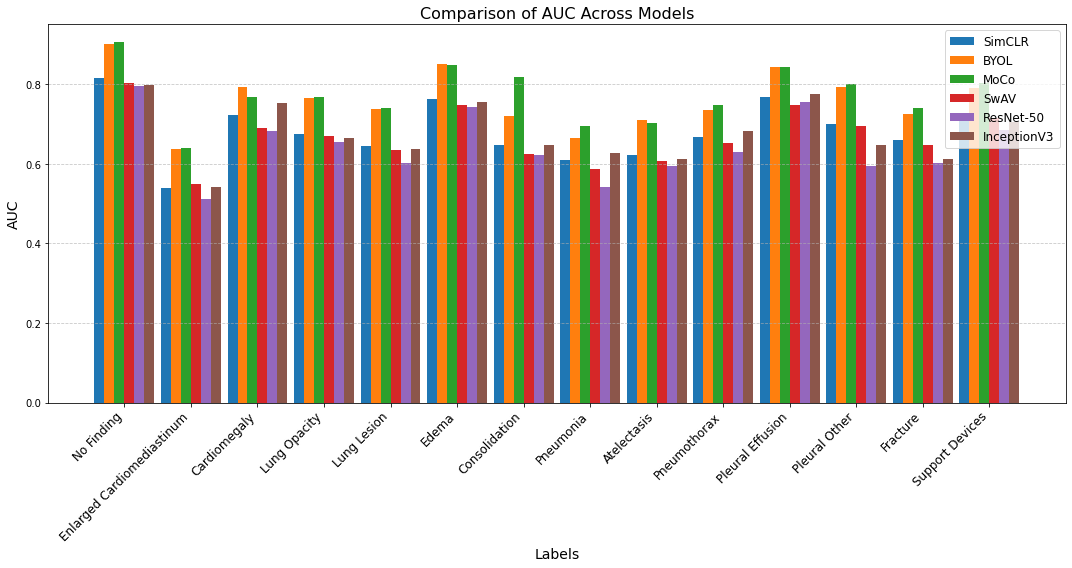

In [47]:
# Function to create merged bar plots for all models
def plot_merged_metrics(models, metric_name, metric_values):
    x = np.arange(len(labels))  # The label locations
    width = 0.15  # Width of the bars

    fig, ax = plt.subplots(figsize=(15, 8))

    for i, (model, values) in enumerate(zip(models, metric_values)):
        ax.bar(x + i * width, values, width, label=model)

    ax.set_title(f"Comparison of {metric_name} Across Models", fontsize=16)
    ax.set_ylabel(metric_name, fontsize=14)
    ax.set_xlabel("Labels", fontsize=14)
    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

# Model names
models = ["SimCLR", "BYOL", "MoCo", "SwAV", "ResNet-50", "InceptionV3"]

# Metric values for each model
auc_values = [simclr_auc, byol_auc, moco_auc, swav_auc, resnet50_auc, inceptionv3_auc]
f1_values = [simclr_f1, byol_f1, moco_f1, swav_f1, resnet50_f1, inceptionv3_f1]
cohen_kappa_values = [simclr_cohen_kappa, byol_cohen_kappa, moco_cohen_kappa, swav_cohen_kappa, resnet50_cohen_kappa, inceptionv3_cohen_kappa]
avg_precision_values = [simclr_avg_precision, byol_avg_precision, moco_avg_precision, swav_avg_precision, resnet50_avg_precision, inceptionv3_avg_precision]

# Plotting
plot_merged_metrics(models, "AUC", auc_values)

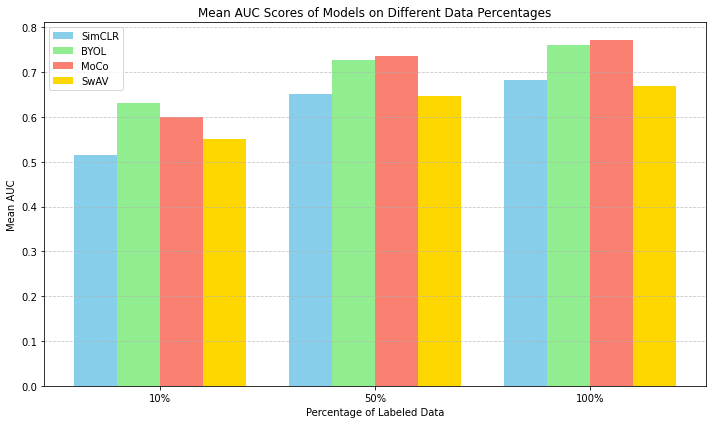

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Provided AUC scores for each model
auc_scores = {
    "SimCLR": {
        "10%": [0.5600592986799261, 0.5271161646902397, 0.4575858493083841, 0.481312839495492, 0.5079440368777581, 0.5458561819385287, 0.4820495585896105, 0.5231848461166313, 0.49345460074335046, 0.5805284311878651, 0.4591321304540984, 0.5352046211864236, 0.5403147322422446, 0.5035332003182493],
        "50%": [0.7923802069445999, 0.5134892413996605, 0.6498793190086924, 0.661239090311723, 0.6252694859038141, 0.7430027635170251, 0.6297391887902786, 0.5625094405295891, 0.5941256780807438, 0.6279916991719745, 0.7181966167779051, 0.6754863619131233, 0.6323077608085845, 0.6956427280633044],
        "100%": [0.8147164513893396, 0.5383811417024411, 0.721633179721715, 0.6750233539940221, 0.6444237147595355, 0.7614397305162097, 0.6472514053563883, 0.6083838470075984, 0.6216401092635541, 0.6683212120199024, 0.7685373115558345, 0.6989215236346948, 0.6590019061188749, 0.7149298895378599],
    },
    "BYOL": {
        "10%": [0.6876350354043172, 0.6414146231906479, 0.6561243572952429, 0.6532080457213011, 0.56633481603283017, 0.6787578179377637, 0.6366718909609092, 0.5952124201249105, 0.5621246929175514, 0.610772640506832, 0.6904754558010811, 0.57936478639982444, 0.6451503515753927, 0.6439150481794203],
        "50%": [0.8584212153271098, 0.58985439766711325, 0.6932829398989998, 0.7401496097539875, 0.7208925359080304, 0.8112184074264455, 0.685504282434691, 0.6414496713053871, 0.6856830065597706, 0.7238620999146837, 0.7944245289868225, 0.7703453917832273, 0.7269710520122381, 0.7464263503498071],
        "100%": [0.8996366779707136, 0.6363619068553636, 0.7914104513592702, 0.7653999377913455, 0.737268108609495, 0.8508503129307998, 0.7188559857457467, 0.6638207164075857, 0.7096924541289899, 0.7350265239454875, 0.8439654272697572, 0.7918909751182234, 0.7254582424269409, 0.789251219647582],
    },
    "MoCo": {
        "10%": [0.597456915212349, 0.5861991077257759, 0.5570157749460104, 0.5976900402296365, 0.5895009416195857, 0.6122439374323251, 0.6101418204754107, 0.58618672656067, 0.5986998657637046, 0.647610658954974, 0.6349044414567656, 0.55109593551090443, 0.6228170627676394, 0.6150876522118126],
        "50%": [0.8534355884346854, 0.6135102968732173, 0.7219837933318934, 0.742135935179406, 0.7193940256345392, 0.814903831456033, 0.6961350841090136, 0.650117445660859, 0.6851221612772547, 0.7196344543190858, 0.799013898540503, 0.770657661073089, 0.741163403931114, 0.7654270514030316],
        "100%": [0.9045559714534367, 0.6389045419493724, 0.7686279600294667, 0.7664468507383673, 0.7389134834303061, 0.8490804747248747, 0.8176131983511618, 0.6959239897812424, 0.7024891512287984, 0.7466473456445244, 0.8424756033843458, 0.7990053275335715, 0.7397057212543209, 0.802277703423648],
    },
    "SwAV": {
        "10%": [0.6755828413062442, 0.46741150279933263, 0.44926283633902564, 0.5414720328840714, 0.5047286519380498, 0.6192802413864935, 0.5246021784882252, 0.5221784035708734, 0.4952435154704987, 0.5705775315082355, 0.6370081836324757, 0.5574904722948301, 0.5643631393219533, 0.5966391590650705],
        "50%": [0.7849391361643756, 0.5104300752203059, 0.6395814986356271, 0.6551161468536222, 0.6147395086713325, 0.7416088119720649, 0.6083116185330777, 0.5537226334097333, 0.5975363630399262, 0.631613546982198, 0.7184466764162375, 0.6877426821238303, 0.6261609338215599, 0.6788065545392682],
        "100%": [0.8037662259469712, 0.5480403775291207, 0.6904991323137323, 0.6698926334241745, 0.6333111982460579, 0.7481825983032133, 0.6254293584099456, 0.5864404989415661, 0.6064061121773878, 0.6521660686375803, 0.746283705381452, 0.6945876648642176, 0.647793651500406, 0.7143583050136614],
    },
}

# Calculate mean AUC scores
mean_aucs = {model: [np.mean(auc_scores[model]["10%"]),
                     np.mean(auc_scores[model]["50%"]),
                     np.mean(auc_scores[model]["100%"])] for model in auc_scores}

# Plot mean AUC scores
labels = ["10%", "50%", "100%"]
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
width = 0.2  # Bar width
offsets = [-1.5 * width, -0.5 * width, 0.5 * width, 1.5 * width]
colors = ["skyblue", "lightgreen", "salmon", "gold"]

for i, (model, auc) in enumerate(mean_aucs.items()):
    plt.bar(x + offsets[i], auc, width, label=model, color=colors[i])

# Add labels and title
plt.xticks(x, labels)
plt.xlabel("Percentage of Labeled Data")
plt.ylabel("Mean AUC")
plt.title("Mean AUC Scores of Models on Different Data Percentages")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


## We haven't plotted results for F1 score and Cohen Kappa because both metrics rely on true positive, false positive, and false negative predictions, which are highly sensitive to class imbalance and sparse positive labels in medical datasets like CheXpert. This can lead to misleading results in cases where certain classes have very few or no positive predictions, causing F1 and Cohen Kappa to be zero or undefined for those classes. Therefore, we focus on more stable and informative metrics like AUC, which are less impacted by imbalance, to evaluate overall model performance across all classes. We did use techniques to address class imbalance such as WeightedRandomSampler and Focal Loss, however, despite these techniques, metrics like F1 score and Cohen Kappa remain highly sensitive to class imbalance and sparse positive labels. Even with these techniques, the inherent nature of the CheXpert dataset (with some classes having very few positive examples) can still result in: F1 Score being zero for classes where the model does not make positive predictions (possibly due to overfitting on dominant classes or insufficient representation of minority classes); Cohen Kappa being zero or close to zero when the model's predictions for certain classes are skewed heavily toward the majority class or when there’s low agreement between predicted and actual positive labels. These limitations make metrics like AUC (which focus on ranking performance and are less influenced by absolute thresholds) more reliable for evaluating performance across all classes in this context.

In [33]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import random


Image 1: /home/ubuntu/.cache/kagglehub/datasets/ashery/chexpert/versions/1/train/patient58604/study1/view1_frontal.jpg
Class Probabilities:
No Finding: 0.0729
Enlarged Cardiomediastinum: 0.1830
Cardiomegaly: 0.1438
Lung Opacity: 0.3882
Lung Lesion: 0.0459
Edema: 0.2568
Consolidation: 0.1465
Pneumonia: 0.0741
Atelectasis: 0.2299
Pneumothorax: 0.0811
Pleural Effusion: 0.2799
Pleural Other: 0.0190
Fracture: 0.0821
Support Devices: 0.4936

Image 2: /home/ubuntu/.cache/kagglehub/datasets/ashery/chexpert/versions/1/train/patient29818/study1/view1_frontal.jpg
Class Probabilities:
No Finding: 0.0612
Enlarged Cardiomediastinum: 0.1713
Cardiomegaly: 0.1644
Lung Opacity: 0.4169
Lung Lesion: 0.0446
Edema: 0.2837
Consolidation: 0.1484
Pneumonia: 0.0742
Atelectasis: 0.2292
Pneumothorax: 0.0530
Pleural Effusion: 0.3058
Pleural Other: 0.0185
Fracture: 0.0648
Support Devices: 0.4819

Image 3: /home/ubuntu/.cache/kagglehub/datasets/ashery/chexpert/versions/1/train/patient08455/study1/view1_frontal.jpg


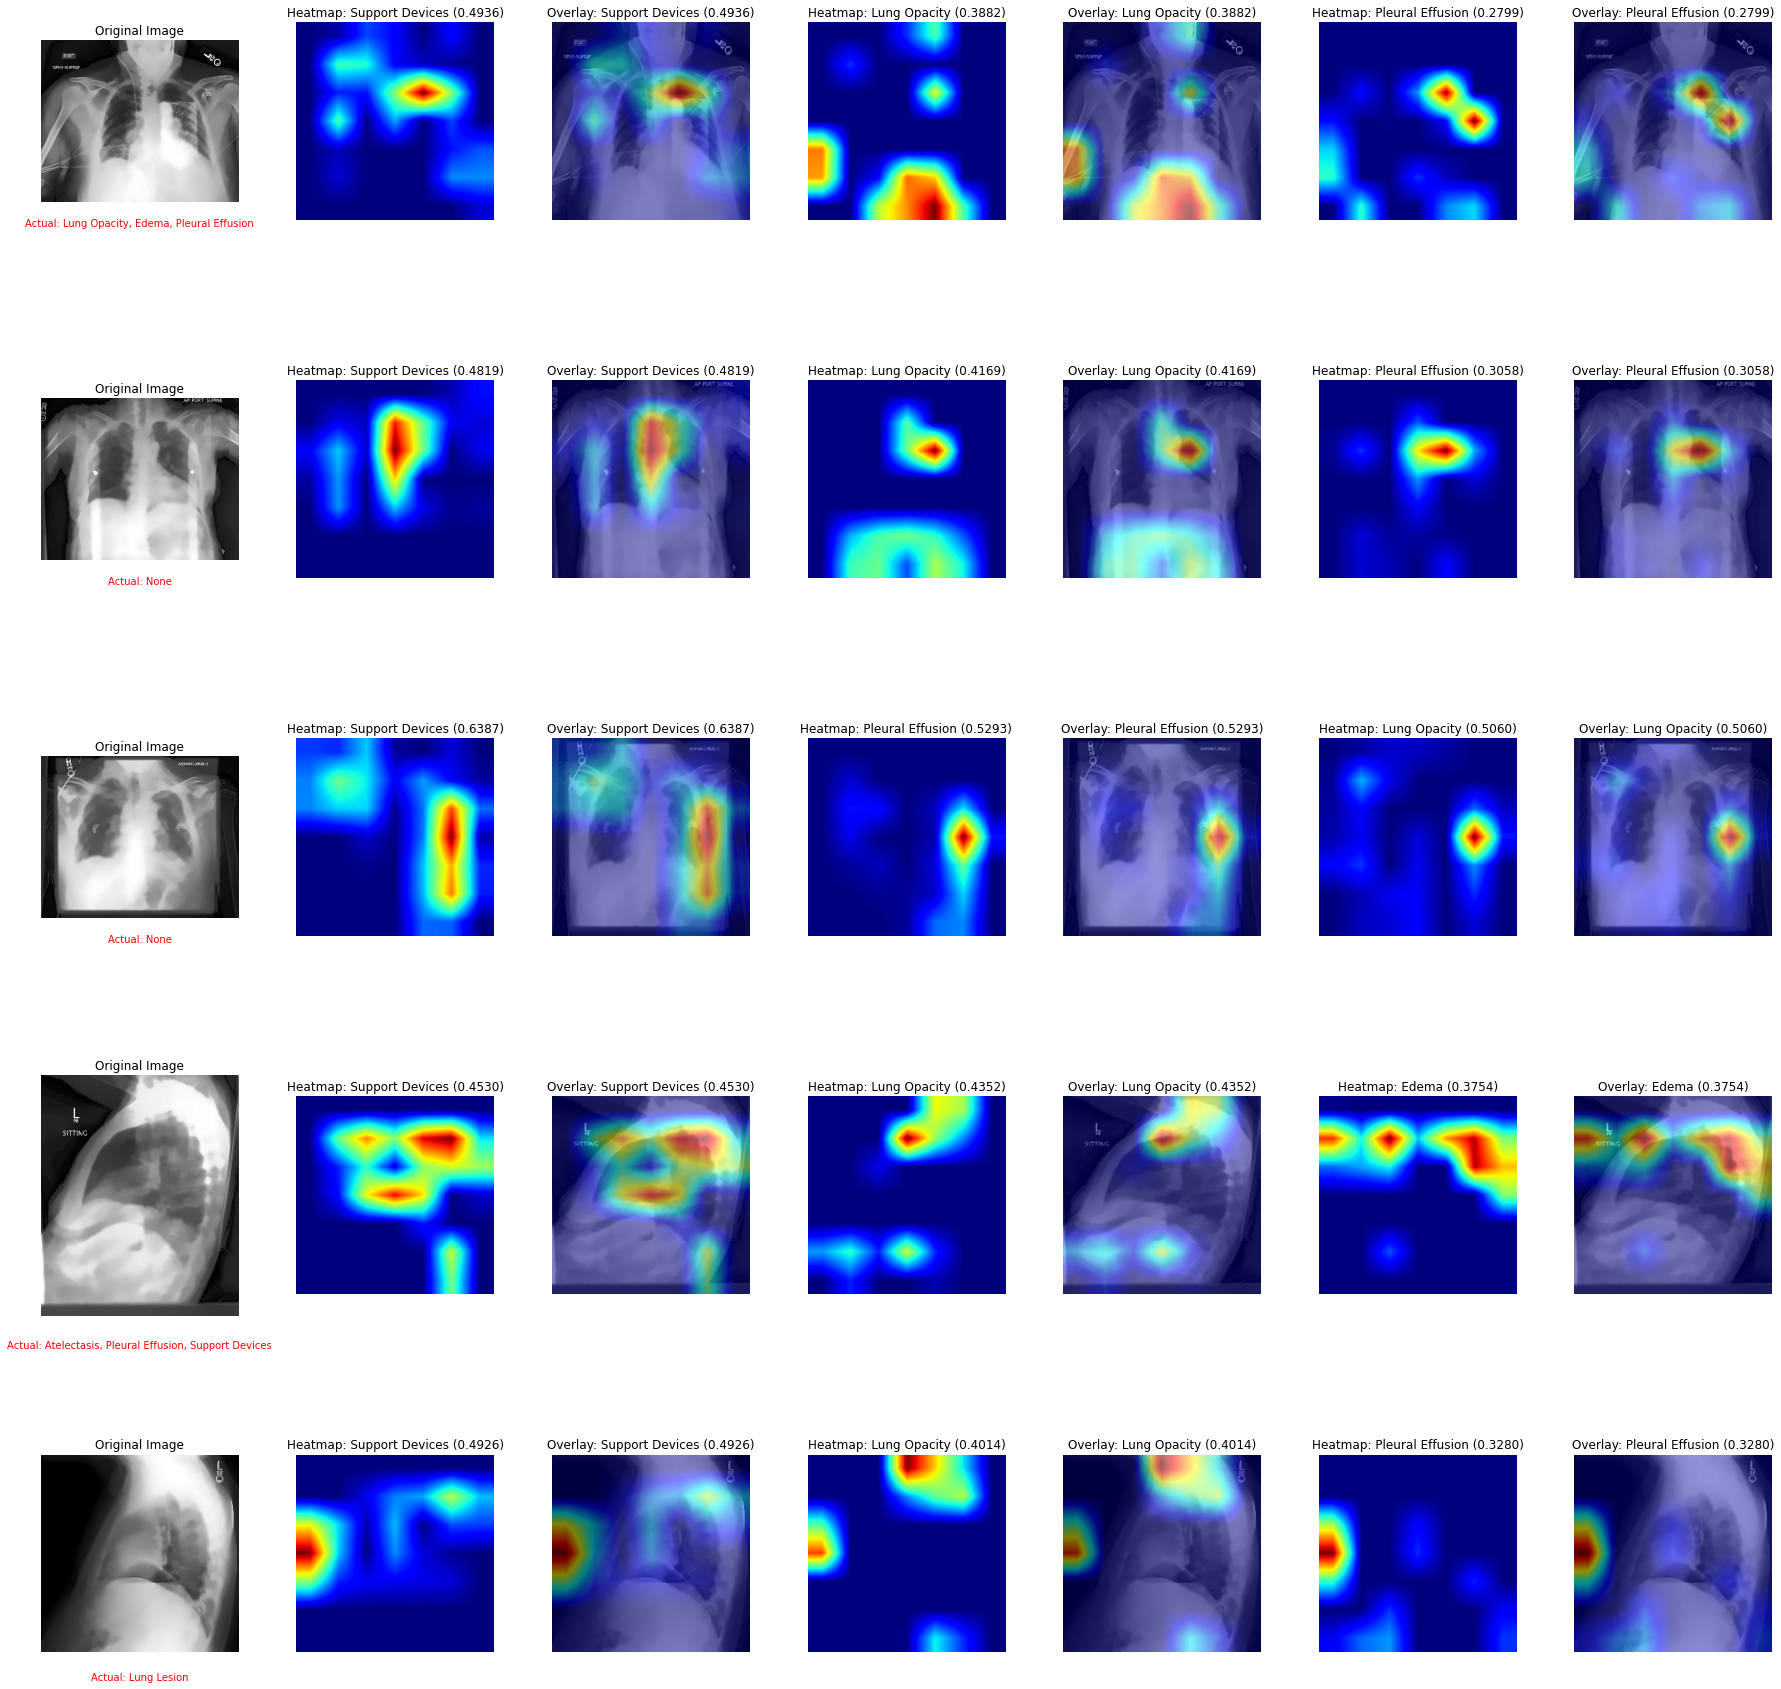

In [51]:
classification_model = moco_model_100
classification_model.eval()
num_images = 5

# Ensure there are enough images in the test set
if num_images > len(test_paths):
    raise ValueError("num_images is greater than the number of available test images.")

# Select 5 random indices from the test set
random_indices = random.sample(range(len(test_paths)), num_images)

# Identify the target layer for Grad-CAM
try:
    target_layer = classification_model[0].layer4[-1]
except AttributeError:
    raise AttributeError("The target layer 'layer4[-1]' was not found in the backbone. Please verify the model architecture.")

# Initialize Grad-CAM using a context manager without 'use_cuda'
with GradCAM(model=classification_model, target_layers=[target_layer]) as cam:
    # Prepare subplots: num_images rows x 7 columns (Original, Heatmap + Overlay for top 3 classes)
    fig, axes = plt.subplots(num_images, 7, figsize=(25, 5 * num_images))

    for idx, sample_idx in enumerate(random_indices):
        img_path = test_paths[sample_idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read in color
        if img is None:
            print(f"Failed to load image at {img_path}. Skipping.")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Apply denoising suitable for color images
        img = cv2.fastNlMeansDenoisingColored(img, None, h=10, hColor=10)

        # Convert to YCrCb for histogram equalization
        img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        y, cr, cb = cv2.split(img_y_cr_cb)
        y = cv2.equalizeHist(y)
        img_y_cr_cb = cv2.merge([y, cr, cb])
        img = cv2.cvtColor(img_y_cr_cb, cv2.COLOR_YCrCb2RGB)

        # Convert to float32 and normalize per channel if needed
        img = img.astype(np.float32) / 255.0

        # Convert back to PIL image for transform
        pil_img = torchvision.transforms.ToPILImage()(img)

        arr_img = np.array(pil_img)

        # Apply test_transform (assuming it starts with T.ToPILImage())
        input_tensor = test_transform(arr_img).unsqueeze(0).to(device)

        # Forward pass to get probabilities
        with torch.no_grad():
            logits = classification_model(input_tensor)
            probs = torch.sigmoid(logits).cpu().numpy()[0]

        # Print probabilities for each class
        print(f"\nImage {idx+1}: {img_path}")
        print("Class Probabilities:")
        for i, cls in enumerate(target_columns):
            print(f"{cls}: {probs[i]:.4f}")

        # Get top 3 predicted classes
        top_classes = np.argsort(probs)[-3:][::-1]  # Indices of top 3 classes

        # Get actual labels for the current image
        actual_labels = [target_columns[i] for i, val in enumerate(test_label_dict[img_path].values()) if val == 1]
        actual_label_str = ', '.join(actual_labels) if actual_labels else "None"

        # Plot Original Image
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title("Original Image")
        axes[idx, 0].axis('off')
        # Add actual label text above the image
        axes[idx, 0].text(
            0.5, -0.1, f"Actual: {actual_label_str}",
            fontsize=10, color='red', ha='center', va='top', transform=axes[idx, 0].transAxes
        )

        for cam_idx, target_class in enumerate(top_classes):
            # Define the target for Grad-CAM
            targets = [ClassifierOutputTarget(target_class)]

            # Compute Grad-CAM
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

            # Prepare the image for visualization
            pil_img_resized = pil_img.resize((224, 224))
            rgb_img_float = np.array(pil_img_resized).astype(np.float32) / 255.0

            # Compute Grad-CAM visualization
            visualization = show_cam_on_image(rgb_img_float, grayscale_cam, use_rgb=True)

            # Plot Heatmap
            axes[idx, 1 + cam_idx * 2].imshow(grayscale_cam, cmap='jet')
            axes[idx, 1 + cam_idx * 2].set_title(f"Heatmap: {target_columns[target_class]} ({probs[target_class]:.4f})")
            axes[idx, 1 + cam_idx * 2].axis('off')

            # Plot Grad-CAM Overlay
            axes[idx, 2 + cam_idx * 2].imshow(visualization)
            axes[idx, 2 + cam_idx * 2].set_title(f"Overlay: {target_columns[target_class]} ({probs[target_class]:.4f})")
            axes[idx, 2 + cam_idx * 2].axis('off')

    plt.tight_layout()
    plt.show()